<a href="https://colab.research.google.com/github/chitinglow/Covid19/blob/master/Covid19_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install mplfinance
!pip install chart_studio

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import dates
import mplfinance as mpf
%matplotlib inline
import statsmodels.api as sm
import seaborn as sns

import chart_studio.plotly as py
import plotly.express as px
import plotly.graph_objects as go

import cufflinks as cf # Connects Plotly to Pandas
# Makes Plotly work in your Notebook
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()

import requests # Get URL data
from bs4 import BeautifulSoup # Manipulate URL data
import json
from pandas import DataFrame as df

## Grab Data From URL

In [4]:
#Get webpage data
web_page = requests.get("https://www.worldometers.info/coronavirus")
#parse the data into HTML
soup = BeautifulSoup(web_page.text, 'html.parser')

## Grab Basic Data

In [5]:
# Find basic data in div with class name maincounter-number
covid_data = soup.find_all("div",class_ = "maincounter-number")
# 
print("Coronavirus Cases: ", covid_data[0].text.strip())
print("Deaths: ", covid_data[1].text.strip())
print("Recovered: ", covid_data[2].text.strip())

# If I wanted world data I could search for script tags with type
# set as text/javascript
data = soup.find_all("script", {"type":"text/javascript"})
# for content in data:
#     print(content)

Coronavirus Cases:  54,318,729
Deaths:  1,318,038
Recovered:  37,866,568


In [6]:
## Get Table data
results = soup.find(id = 'main_table_countries_today')
content = results.find_all('td')

clean_data = ""
for data in content:
  #Separate text data
  clean_data += data.text.strip() + "|"
  #replace + to blank space
  clean_data = clean_data.replace("+", "")
  #filling blank space
  clean_data = clean_data.replace("N/A","0")
clean_data

'|North America|13,248,961|5,860|376,274|635|8,408,160|4,021|4,464,527|24,370||||||North America|||||Asia|14,999,546|230|264,789|1|13,371,790|71|1,362,967|24,452||||||Asia|||||South America|10,324,962||309,398||9,311,138||704,426|17,410||||||South America|||||Europe|13,727,389||319,427||5,081,798||8,326,164|29,256||||||Europe|||||Africa|1,975,039||47,141||1,660,128||267,770|2,609||||||Africa|||||Oceania|42,111|12|994||32,895||8,222|26||||||Australia/Oceania||||||721||15||659||47|4|||||||||||World|54,318,729|6,102|1,318,038|636|37,866,568|4,092|15,134,123|98,127|6,969|169.1||||All||||1|USA|11,226,038||251,256||6,891,015||4,083,767|20,415|33,841|757|166,750,395|502,673|331,727,464|North America|30|1,320|2|2|India|8,814,902||129,674||8,203,737||481,491|8,944|6,364|94|124,031,230|89,550|1,385,049,027|Asia|157|10,681|11|3|Brazil|5,848,959||165,673||5,291,511||391,775|8,318|27,444|777|21,900,000|102,758|213,122,892|South America|36|1,286|10|4|France|1,954,599||44,246||139,140||1,771,213|4,87

In [7]:

import re

# Got a list of countries from the website
countries = [
    'usa', 'spain', 'italy', 'france', 'germany', 'uk', 'turkey', 'iran', 
    'russia', 'brazil', 'canada', 'belgium', 'netherlands', 'switzerland', 
    'india', 'peru', 'portugal', 'ecuador', 'ireland', 'sweden', 'saudi-arabia', 
    'israel', 'austria', 'mexico', 'singapore', 'japan', 'chile', 'pakistan', 
    'poland', 'romania', 'belarus', 'qatar', 'south-korea', 'united-arab-emirates', 
    'indonesia', 'ukraine', 'denmark', 'serbia', 'philippines', 'norway', 
    'czech-republic', 'australia', 'dominican-republic', 'bangladesh', 'malaysia', 
    'panama', 'colombia', 'finland', 'south-africa', 'egypt', 'morocco', 'argentina', 
    'luxembourg', 'moldova', 'algeria', 'kuwait', 'thailand', 'kazakhstan', 
    'bahrain', 'hungary', 'greece', 'oman', 'croatia', 'uzbekistan', 'iraq', 
    'armenia', 'iceland', 'afghanistan', 'estonia', 'azerbaijan', 'cameroon', 
    'bosnia-and-herzegovina', 'ghana', 'new-zealand', 'lithuania', 'slovenia', 
    'macedonia', 'slovakia', 'cuba', 'bulgaria', 'nigeria', 'cote-d-ivoire', 
    'china-hong-kong-sar', 'djibouti', 'guinea', 'bolivia', 'tunisia', 'latvia', 
    'cyprus', 'andorra', 'albania', 'lebanon', 'niger', 'kyrgyzstan', 'costa-rica', 
    'senegal', 'honduras', 'burkina-faso', 'uruguay', 'sri-lanka', 'san-marino', 
    'channel-islands', 'guatemala', 'georgia', 'democratic-republic-of-the-congo', 
    'malta', 'jordan', 'somalia', 'taiwan', 'reunion', 'mayotte', 'mali', 'kenya', 
    'jamaica', 'state-of-palestine', 'mauritius', 'venezuela', 'el-salvador', 
    'montenegro', 'isle-of-man', 'tanzania', 'viet-nam', 'equatorial-guinea', 
    'sudan', 'paraguay', 'maldives', 'congo', 'rwanda', 'faeroe-islands', 'gabon', 
    'martinique', 'guadeloupe', 'myanmar', 'gibraltar', 'brunei-darussalam', 
    'liberia', 'ethiopia', 'madagascar', 'cambodia', 'trinidad-and-tobago', 
    'french-guiana', 'bermuda', 'cabo-verde', 'aruba', 'togo', 'monaco', 
    'sierra-leone', 'zambia', 'liechtenstein', 'bahamas', 'barbados', 'uganda', 
    'mozambique', 'sint-maarten', 'guyana', 'haiti', 'cayman-islands', 'benin', 
    'libya', 'swaziland', 'french-polynesia', 'guinea-bissau', 'nepal', 'chad', 
    'china-macao-sar', 'syria', 'eritrea', 'saint-martin', 'mongolia', 'malawi', 
    'zimbabwe', 'angola', 'antigua-and-barbuda', 'timor-leste', 'botswana', 
    'central-african-republic', 'laos', 'belize', 'fiji', 'grenada', 'new-caledonia', 
    'curacao', 'dominica', 'namibia', 'saint-kitts-and-nevis', 'saint-lucia', 
    'saint-vincent-and-the-grenadines', 'nicaragua', 'falkland-islands-malvinas', 
    'burundi', 'montserrat', 'turks-and-caicos-islands', 'greenland', 'seychelles', 
    'gambia', 'suriname', 'holy-see', 'papua-new-guinea', 'mauritania', 'bhutan', 
    'british-virgin-islands', 'saint-barthelemy', 'south-sudan', 'western-sahara', 
    'caribbean-netherlands', 'sao-tome-and-principe', 'anguilla', 'saint-pierre-and-miquelon', 
    'yemen', 'china'
]

# Cycle through countries
for c in countries:
    # Add country name plus look for all , | and any numbers that follow
    pattern = c+"[,|\d]*"
    # Search for the pattern and ignore case so I don't have to worry about
    # country capitalization
    data = re.search(pattern, clean_data, re.IGNORECASE)
    # If data is a NoneType ignore it
    #if data is not None:
    #     print(data.group())



## Working with CSV Data

In [8]:
owid_df = pd.read_csv("https://raw.githubusercontent.com/derekbanas/Covid-19-Data-Analysis/main/owid-covid-data.csv")
owid_df.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'tests_per_case', 'positive_rate', 'tests_units', 'stringency_index',
       'population', 'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'handwashing_facilities', 'hospital_beds_per_thousand',
       'life_expectancy', 'human_development_index'],
      dtype='object')

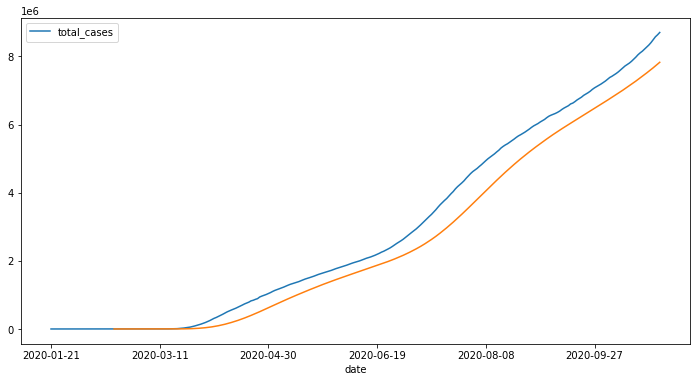

In [9]:
# Create Numpy array of unique countries
country_df = owid_df.location.unique()
country_df # Show countries
country_df.size # How many countries (214)

# Get indexes for location rows equal to United States
indexer = owid_df[owid_df['location']=='United States'].index
# Get dataframe location and total cases for United States
us_tc = owid_df.loc[indexer, 'date':'total_cases']
# Delete NaN values
us_tc = us_tc.dropna()
# Set date as index
us_tc.set_index('date', inplace=True)
us_tc.plot(figsize=(12,6))

# Plot a 30 day moving average
us_tc.rolling(window=30).mean()['total_cases'].plot()

# owid_df.columns
# country_df

## Does lockdown work

Index(['new_cases_per_million'], dtype='object')
Index(['new_cases_per_million'], dtype='object')


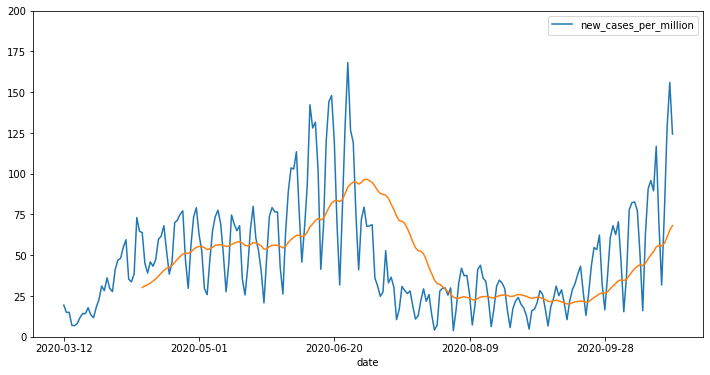

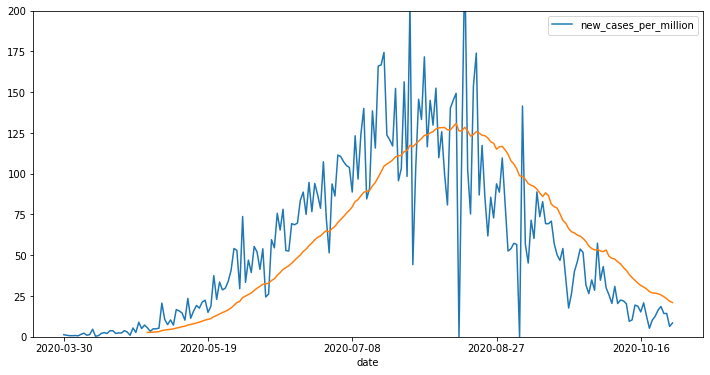

In [10]:
def plot_covid_data(country, col, plot_ma=False, y_max=200):
    # Get indexes for location rows equal to country name
    indexer = owid_df[owid_df['location']==country].index
    # Get dataframe location and column data for country name
    country_df = owid_df.loc[indexer, 'date':col]
    # Delete NaN values
    country_df = country_df.dropna()
    # Set date as index
    country_df.set_index('date', inplace=True)
    # Remove all columns except for what I want
    country_df.drop(country_df.columns.difference([col]), 1, inplace=True)
    country_df.plot(figsize=(12,6), ylim=[0,y_max])

    # Plot moving average if requested
    if plot_ma:
        # Plot a 30 day moving average
        country_df.rolling(window=30).mean()[col].plot()
    print(country_df.columns)
    
# Least restrictive lockdown
plot_covid_data('Sweden', 'new_cases_per_million', True)
# Most restrictive lockdown measures
plot_covid_data('Bolivia', 'new_cases_per_million', True) 

# owid_df.columns

## How does median age effec death rate

Index(['new_deaths_per_million'], dtype='object')
Index(['new_deaths_per_million'], dtype='object')


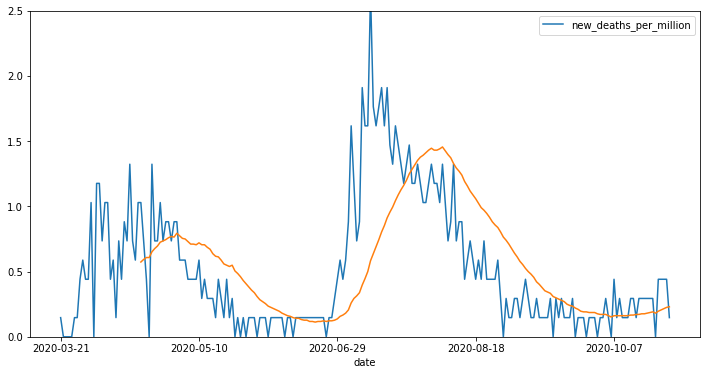

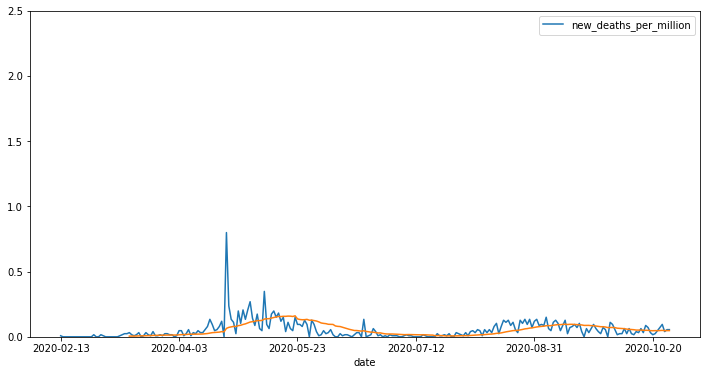

In [11]:
# Country with lowest median age
plot_covid_data('Serbia', 'new_deaths_per_million', True, 2.5)
# Country with highest median age
plot_covid_data('Japan', 'new_deaths_per_million', True, 2.5)

## How Does Obesity Effect Death Rate?

Index(['new_deaths_per_million'], dtype='object')
Index(['new_deaths_per_million'], dtype='object')
Index(['new_deaths_per_million'], dtype='object')
Index(['new_deaths_per_million'], dtype='object')


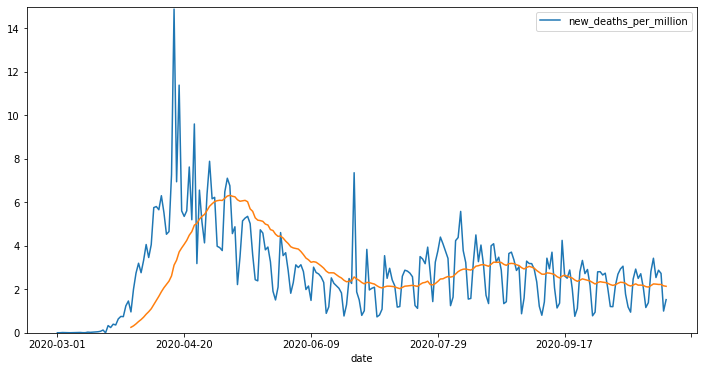

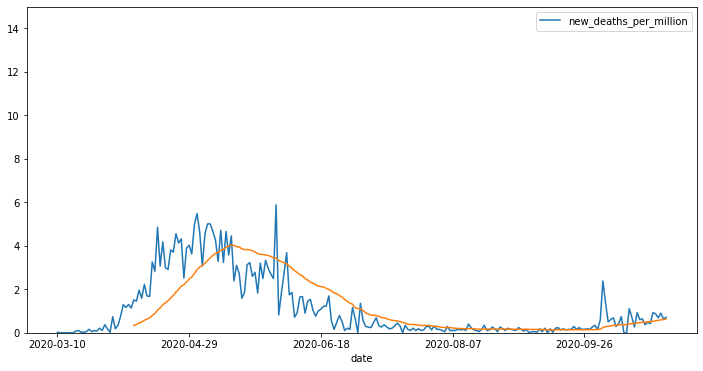

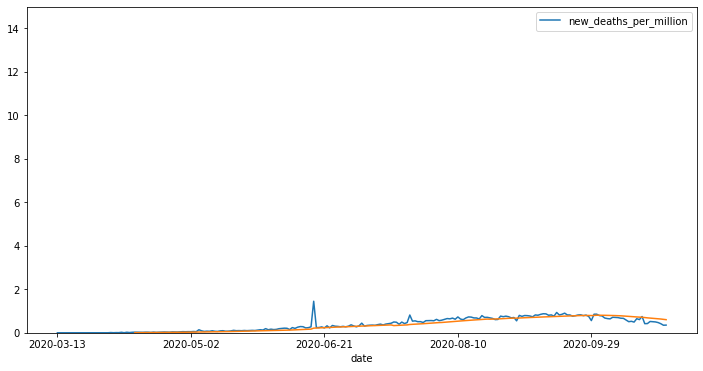

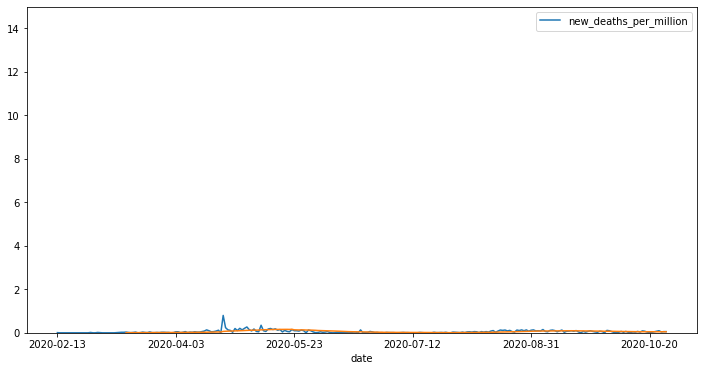

In [12]:
# Countries with highest percentages 
plot_covid_data('United States', 'new_deaths_per_million', True, 15)
plot_covid_data('Canada', 'new_deaths_per_million', True, 15)
# 2 countries with lowest percentages
plot_covid_data('India', 'new_deaths_per_million', True, 15)
plot_covid_data('Japan', 'new_deaths_per_million', True, 15)

## How does diabetes prevalance effect death?**bold text**

Index(['new_deaths_per_million'], dtype='object')
Index(['new_deaths_per_million'], dtype='object')


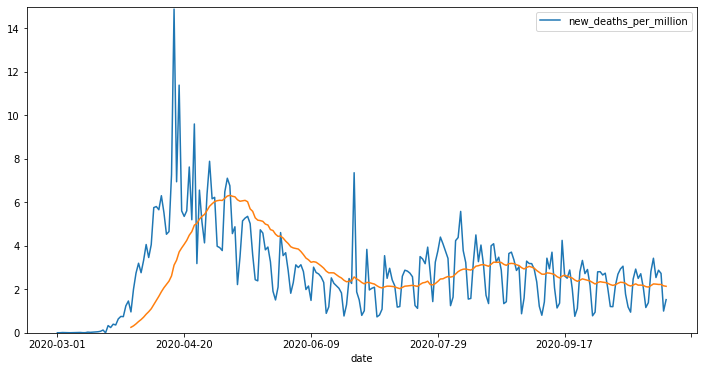

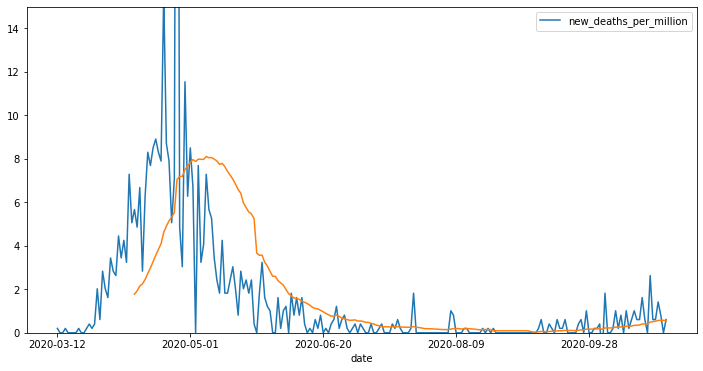

In [13]:
# Country with highest percentage 
plot_covid_data('United States', 'new_deaths_per_million', True, 15)
# Country with lowest percentage
plot_covid_data('Ireland', 'new_deaths_per_million', True, 15)

## Does More Testing Slow Deathrate?

Index(['new_deaths_per_million'], dtype='object')
Index(['new_deaths_per_million'], dtype='object')


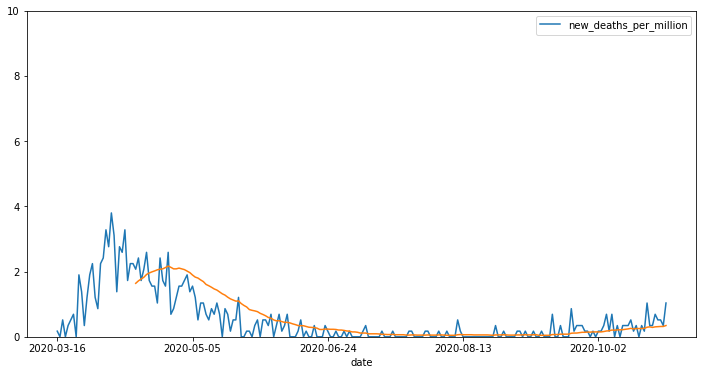

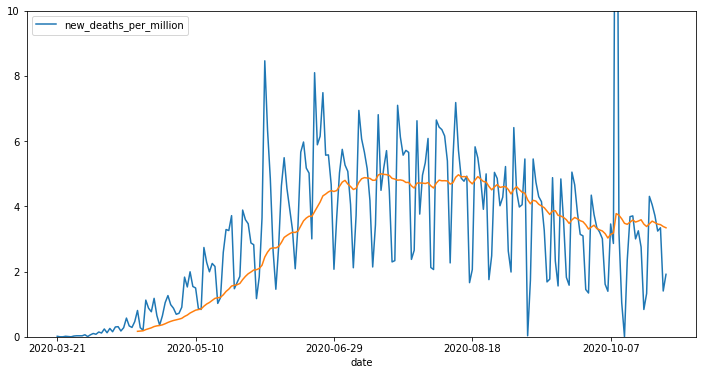

In [14]:
# Country with highest percentage 
plot_covid_data('Denmark', 'new_deaths_per_million', True, 10)
# Country with lowest percentage
plot_covid_data('Mexico', 'new_deaths_per_million', True, 10)

In [15]:
# Receives date and column of interest for every country as a dataframe
def scatter_plot(date, col1, col2):
    tot_df = pd.DataFrame(columns = ['date', 'location', col1, col2])
    # temp_df = pd.DataFrame()
    for c in country_df:
        # Get country specific data and append to main dataframe
        temp_df = owid_df[(owid_df['location']==c) & (owid_df['date']==date)][['date', 'location', col1, col2]]
        tot_df = tot_df.append(temp_df, ignore_index = True).fillna(0)
    tot_df.set_index('date', inplace=True)
    
    # Create Plotly scatter plot
    fig = px.scatter(data_frame=tot_df, x=col2, 
                     y=col1, color="location", trendline="ols",
                 hover_data=['location'])
    fig.show()
    
    return tot_df

# Try median_age, aged_70_older, diabetes_prevalence, male_smokers, 
scatter_plot('2020-10-27', 'total_deaths_per_million', 'aged_70_older')

,location,total_deaths_per_million,aged_70_older
date,,,
2020-10-27,Aruba,337.186,7.452
2020-10-27,Afghanistan,39.097,1.337
2020-10-27,Angola,8.154,1.362
2020-10-27,Anguilla,0.000,0.000
2020-10-27,Albania,166.794,8.643
...,...,...,...
2020-10-27,South Africa,320.493,3.053
2020-10-27,Zambia,18.930,1.542
2020-10-27,Zimbabwe,16.282,1.882


In [16]:
## Time Series Forecasting

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import dates
import mplfinance as mpf
%matplotlib inline
import statsmodels.api as sm
import seaborn as sns

import chart_studio.plotly as py
import plotly.express as px
import plotly.graph_objects as go

import cufflinks as cf # Connects Plotly to Pandas
# Makes Plotly work in your Notebook
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()

import requests # Get URL data
from bs4 import BeautifulSoup # Manipulate URL data
import json
from pandas import DataFrame as df

## **Forecasting Intro**
You are going to choose different models depending upon the data you have. We will train our model on the first group of data (Training Data : 1st 80%). Then we test the model using the last part of our data (Test Date : Last 20%). All along we are modeling using real known true results. We should forecast into the future the same length of time we test for.

## Get Our Data

In [17]:
owid_df = pd.read_csv("https://raw.githubusercontent.com/derekbanas/TimeSeriesAnalysis/main/owid-covid-data.csv")
owid_df.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'tests_per_case', 'positive_rate', 'tests_units', 'stringency_index',
       'population', 'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'handwashing_facilities', 'hospital_beds_per_thousand',
       'life_expectancy', 'human_development_index'],
      dtype='object')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 241 entries, 2020-03-01 to 2020-10-27
Freq: D
Data columns (total 1 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   new_deaths_per_million  241 non-null    float64
dtypes: float64(1)
memory usage: 3.8 KB


DatetimeIndex(['2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04',
               '2020-03-05', '2020-03-06', '2020-03-07', '2020-03-08',
               '2020-03-09', '2020-03-10',
               ...
               '2020-10-18', '2020-10-19', '2020-10-20', '2020-10-21',
               '2020-10-22', '2020-10-23', '2020-10-24', '2020-10-25',
               '2020-10-26', '2020-10-27'],
              dtype='datetime64[ns]', name='date', length=241, freq='D')

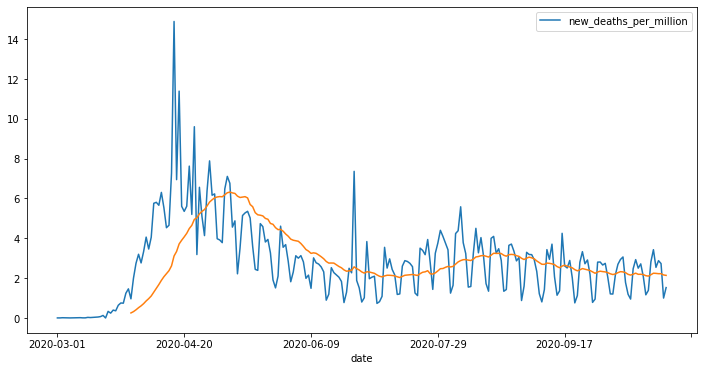

In [18]:
# Create Numpy array of unique countries
covid_df = owid_df.location.unique()
# Get indexes for United States
indexer = owid_df[owid_df['location']=='United States'].index
# Get dataframe location and column data for country name
covid_df = owid_df.loc[indexer, 'date':'new_deaths_per_million']
# Delete NaN values
covid_df = covid_df.dropna()
# Set date as index
covid_df.set_index('date', inplace=True)
# Remove all columns except for what I want
covid_df.drop(covid_df.columns.difference(['new_deaths_per_million']), 1, inplace=True)
covid_df.plot(figsize=(12,6))
# Plot a 30 day moving average
covid_df.rolling(window=30).mean()['new_deaths_per_million'].plot()

covid_df = covid_df.asfreq('d') # Set frequency for daily
# covid_df = covid_df.set_index('date').asfreq('d')
# Get the number of data points we have
covid_df.info() # 241 : 192 Training : 49 Test
# Separate into 2 pieces
train_df = covid_df.iloc[:192]
test_df = covid_df.iloc[191:]

covid_df.index

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning:

After 0.13 initialization must be handled at model creation



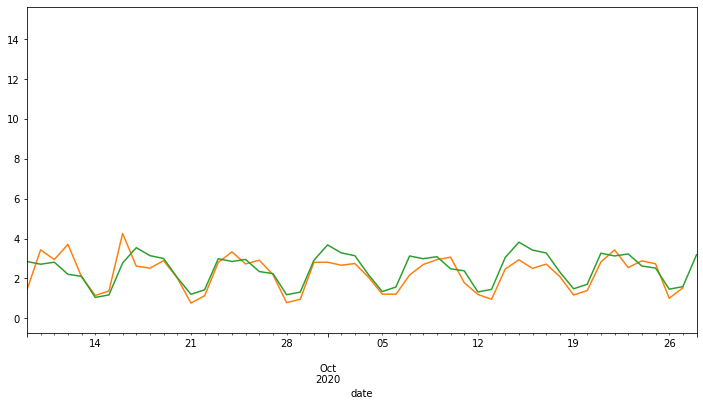

In [19]:
## Holt winters model with training data

# The Holt - Winters Method actually models 3 aspects of the 
# time series being the average, trend and seasonality. 
# In doing so it tries to predict the future provided the 
# series is seasonal and repetitive over time.

from statsmodels.tsa.holtwinters import ExponentialSmoothing

# There is no exponential growth so I'll use additive
# I picked 14 for period because it provided the best result
fit_model = ExponentialSmoothing(train_df['new_deaths_per_million'],
                                  trend='add',
                                  seasonal='add',
                                  seasonal_periods=14).fit()
# We can now make predictions 50 days into the future
prediction = fit_model.forecast(50)
prediction

# Plot training, testing and projection data
train_df['new_deaths_per_million'].plot(figsize=(12,6))
test_df['new_deaths_per_million'].plot()
prediction.plot(xlim=['2020-09-09','2020-10-28'])

## **Evaluating Predictions : Mean Absolute Error**
I'll look at different options for evaluating my forecasts being Mean Absolute, Mean Squared and Root Mean Square Error.

Mean Absolute Error : Take the difference between our prediction and the true result and find the average. The negative is that a few major errors my skew the results.

$$\begin{equation*}
\frac{1}{n}\sum_{n}^{i=1}|y_i - \hat{y}_i|
\end{equation*}$$

In [20]:
def mae(y1, y2, axis=0):
    y1_np = y1.to_numpy()
    y2_np = y2.to_numpy()
    return np.mean(np.abs(y1_np - y2_np), axis=axis)

mae(test_df, prediction, None)

# We'll use the scikit-learn library
# conda install scikit-learn or
# pip install -U scikit-learn

from sklearn.metrics import mean_absolute_error, mean_squared_error

mean_absolute_error(test_df, prediction)
# test_df.mean() # How good are our results

0.8142958498271078

**## Mean Squared Error **
Mean Squared Error : Takes the difference like before and finds the mean, but since we square the results large errors are squared which dramatically shows those errors in the model. The negative is that the units are squared distorting the results.

$$\begin{equation*}
\frac{1}{n}\sum_{n}^{i=1}({y_i - \hat{y}_i})^2
\end{equation*}$$

In [21]:
def mse(y1, y2, axis=0):
    y1_np = y1.to_numpy()
    y2_np = y2.to_numpy()
    return ((y1_np - y2_np) ** 2).mean(axis=axis)
# axis=0 is per-column, ax=1 is per-row and ax=None is total 
mse(test_df, prediction, None)
    
mean_squared_error(test_df, prediction)

0.9720067842549598

## **Root Mean Squared Error**
Root Mean Squared Error : By finding the square root we return to the original unit used. When evaluating how bad an error is it depends on how large your values are. If we found our model was off by 100,000 nationally that wouldn't be as big a deal as if we were off by 100,000 in a small city.

$$\begin{equation*}
\sqrt{\frac{1}{n}\sum_{n}^{i=1}({y_i - \hat{y}_i})^2}
\end{equation*}$$

In [22]:
np.sqrt(mean_squared_error(test_df, prediction))

0.9859040441417003

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning:

After 0.13 initialization must be handled at model creation



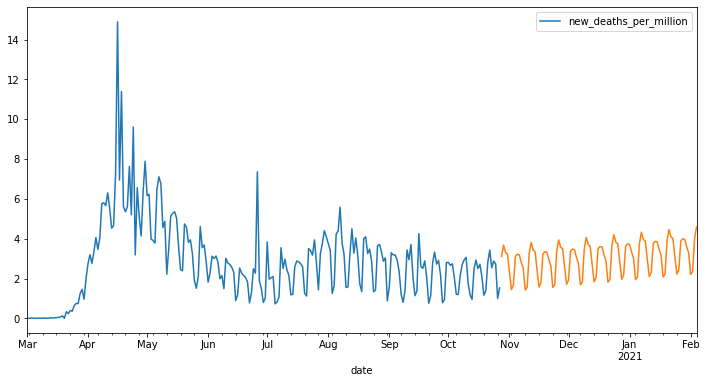

In [23]:
## PRedict future
covid_model = ExponentialSmoothing(covid_df['new_deaths_per_million'],
                                  trend='add',
                                  seasonal='add',
                                  seasonal_periods=14).fit()
# Let's predict 100 days into the future
covid_forecast = covid_model.forecast(100)
# Print original and then our prediction
covid_df.plot(figsize=(12,6))
covid_forecast.plot()

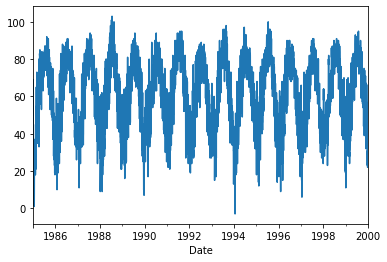

In [24]:
# We are used to working with non-stationary datasets.
# Stationary data is rather flat and the mean, variance 
# and autocorrelation structure do not change over time.
pitt_df = pd.read_csv('https://raw.githubusercontent.com/derekbanas/TimeSeriesAnalysis/main/PittsburghWeather.csv', 
                      index_col='Date', parse_dates=True)
pitt_df['tmax'].plot(xlim=['1985-01-01','2000-01-01'])

## **Auto Correlation Function**
Auto Regressive Integrated Moving Average (ARIMA) based models forecast a time series based on past data and forecast errors.

The ACF and PACF provide parameters for ARIMA models.

2 groups of data that move in like ways are said to be correlated. Correlation is measured between the values of -1 (Inverse Correlation) to 0 (No Relationship) to 1 (Strongly Correlated).

With auto correlation we compare data to itself shifted a defined amount of time. For example we could shift a week and determine if last weeks performance is correlated to this week.

With auto correlation the y access is the correlation and x is the time shift amount. This way we can see how well our data is correlated over time.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:660: FutureWarning:

The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.



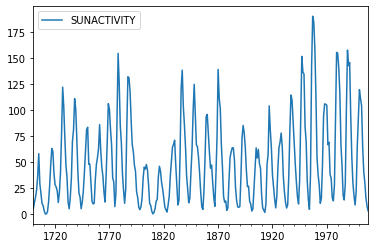

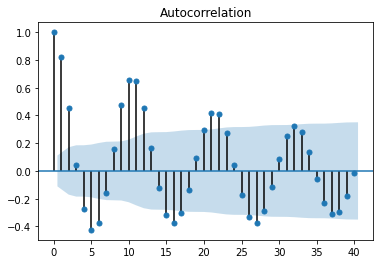

In [25]:
from statsmodels.tsa.stattools import acovf, acf
from statsmodels.graphics.tsaplots import plot_acf

# Load sunspot data
sun_df = sm.datasets.sunspots.load_pandas().data
# Set index
sun_df.index = pd.Index(sm.tsa.datetools.dates_from_range('1700', '2008'))
# Delete year column
del sun_df["YEAR"]
sun_df.plot()

acf(sun_df['SUNACTIVITY'], fft=False)

# Squeeze squeezes single column dataframes to a series
# Lag defines how much we want to shift the data
sm.graphics.tsa.plot_acf(sun_df.values.squeeze(), lags=40);

## **Partial Auto Correlation Function**
An auto correlation has both a direct and indirect correlation. The PAC tries to remove those indirect correlations. With it we look for the difference between our linear model and the actual results. This difference is called the residual. We then plot those residuals.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:995: FutureWarning:

ywunbiased has been renamed ywadjusted. After release 0.13, using the old name will raise.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:735: FutureWarning:

The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:889: FutureWarning:

The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.



array([ 1.        ,  0.82378725, -0.69028693, -0.13025039,  0.05492352,
        0.00182287,  0.16866233,  0.22651075,  0.22199668,  0.25349103,
       -0.00138647,  0.00695794,  0.00144471,  0.00151232,  0.0594618 ,
       -0.07031568, -0.0805838 , -0.16782729, -0.09062848,  0.06411452,
       -0.00115104,  0.13364084, -0.00169989, -0.12925775, -0.04826192,
        0.01734705, -0.07697247,  0.08233459,  0.09805473, -0.10667199,
        0.02903372, -0.02221984, -0.01549459, -0.04568517,  0.02646015,
       -0.00254245, -0.05267785,  0.07981822, -0.02557282,  0.00936012,
        0.06741041])

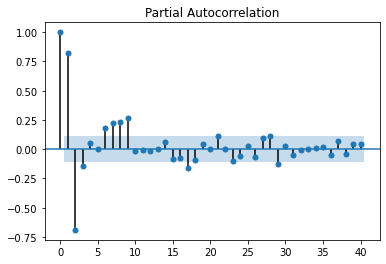

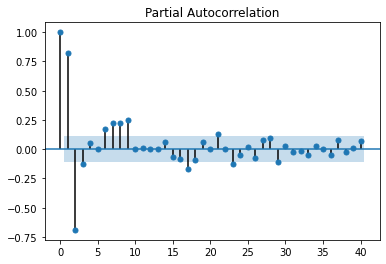

In [26]:

from statsmodels.tsa.stattools import pacf, pacf_yw, pacf_ols
from statsmodels.graphics.tsaplots import plot_pacf

# There are different ways to measure correlation and 
# different ways of measuring partial auto correlation
# Also ywm, ldunbiased, ldbiased (Levinson-Durbin recursion)
sm.graphics.tsa.plot_pacf(sun_df.values.squeeze(), lags=40,
                         method='ywunbiased');

sm.graphics.tsa.plot_pacf(sun_df.values.squeeze(), lags=40,
                         method='ols');

# Non-recursive yule_walker
pacf_yw(sun_df['SUNACTIVITY'])

# Least Squares 
pacf_ols(sun_df['SUNACTIVITY'])

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import dates
import mplfinance as mpf
%matplotlib inline
import statsmodels.api as sm
import seaborn as sns

import chart_studio.plotly as py
import plotly.express as px
import plotly.graph_objects as go

import cufflinks as cf # Connects Plotly to Pandas
# Makes Plotly work in your Notebook
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()

import requests # Get URL data
from bs4 import BeautifulSoup # Manipulate URL data
import json
from pandas import DataFrame as df

## **Forecasting Intro**
You are going to choose different models depending upon the data you have. We will train our model on the first group of data (Training Data : 1st 80%). Then we test the model using the last part of our data (Test Date : Last 20%). All along we are modeling using real known true results. We should forecast into the future the same length of time we test for.

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 241 entries, 2020-03-01 to 2020-10-27
Freq: D
Data columns (total 1 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   new_deaths_per_million  241 non-null    float64
dtypes: float64(1)
memory usage: 3.8 KB


DatetimeIndex(['2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04',
               '2020-03-05', '2020-03-06', '2020-03-07', '2020-03-08',
               '2020-03-09', '2020-03-10',
               ...
               '2020-10-18', '2020-10-19', '2020-10-20', '2020-10-21',
               '2020-10-22', '2020-10-23', '2020-10-24', '2020-10-25',
               '2020-10-26', '2020-10-27'],
              dtype='datetime64[ns]', name='date', length=241, freq='D')

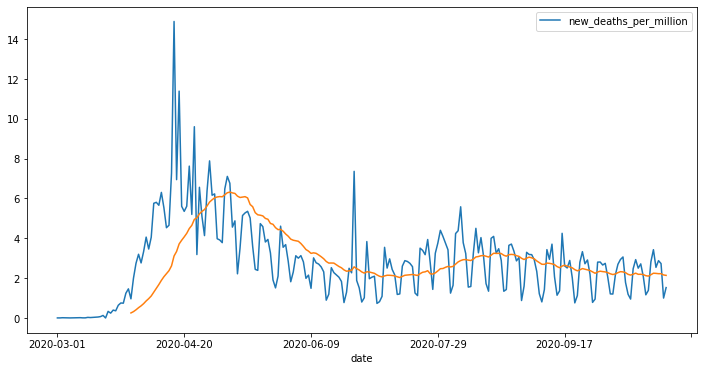

In [28]:
# Import Our World in Data CSV
# https://github.com/owid/covid-19-data/tree/master/public/data
owid_df = pd.read_csv("https://raw.githubusercontent.com/derekbanas/TimeSeriesAnalysis/main/owid-covid-data.csv")
owid_df.columns # Show all columns

# Create Numpy array of unique countries
covid_df = owid_df.location.unique()
# Get indexes for United States
indexer = owid_df[owid_df['location']=='United States'].index
# Get dataframe location and column data for country name
covid_df = owid_df.loc[indexer, 'date':'new_deaths_per_million']
# Delete NaN values
covid_df = covid_df.dropna()
# Set date as index
covid_df.set_index('date', inplace=True)
# Remove all columns except for what I want
covid_df.drop(covid_df.columns.difference(['new_deaths_per_million']), 1, inplace=True)
covid_df.plot(figsize=(12,6))
# Plot a 30 day moving average
covid_df.rolling(window=30).mean()['new_deaths_per_million'].plot()

covid_df = covid_df.asfreq('d') # Set frequency for daily
# covid_df = covid_df.set_index('date').asfreq('d')
# Get the number of data points we have
covid_df.info() # 241 : 192 Training : 49 Test
# Separate into 2 pieces
train_df = covid_df.iloc[:192]
test_df = covid_df.iloc[191:]

covid_df.index

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning:

After 0.13 initialization must be handled at model creation



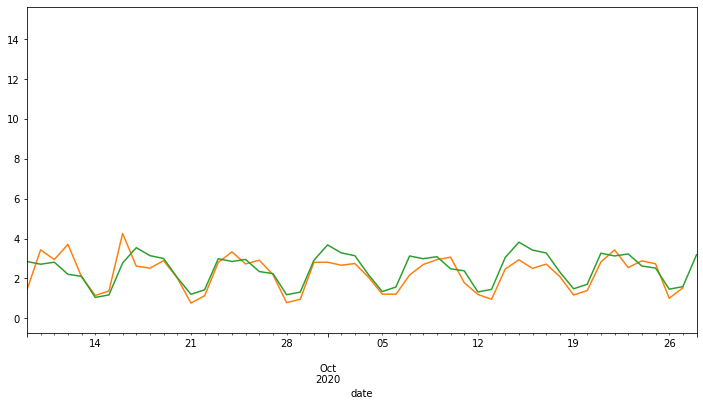

In [29]:
# The Holt - Winters Method actually models 3 aspects of the 
# time series being the average, trend and seasonality. 
# In doing so it tries to predict the future provided the 
# series is seasonal and repetitive over time.

from statsmodels.tsa.holtwinters import ExponentialSmoothing

# There is no exponential growth so I'll use additive
# I picked 14 for period because it provided the best result
fit_model = ExponentialSmoothing(train_df['new_deaths_per_million'],
                                  trend='add',
                                  seasonal='add',
                                  seasonal_periods=14).fit()
# We can now make predictions 50 days into the future
prediction = fit_model.forecast(50)
prediction

# Plot training, testing and projection data
train_df['new_deaths_per_million'].plot(figsize=(12,6))
test_df['new_deaths_per_million'].plot()
prediction.plot(xlim=['2020-09-09','2020-10-28'])

Evaluating Predictions : Mean Absolute Error
I'll look at different options for evaluating my forecasts being Mean Absolute, Mean Squared and Root Mean Square Error.

Mean Absolute Error : Take the difference between our prediction and the true result and find the average. The negative is that a few major errors my skew the results.

$$\begin{equation*}
\frac{1}{n}\sum_{n}^{i=1}|y_i - \hat{y}_i|
\end{equation*}$$

In [30]:
def mae(y1, y2, axis=0):
    y1_np = y1.to_numpy()
    y2_np = y2.to_numpy()
    return np.mean(np.abs(y1_np - y2_np), axis=axis)

mae(test_df, prediction, None)

# We'll use the scikit-learn library
# conda install scikit-learn or
# pip install -U scikit-learn

from sklearn.metrics import mean_absolute_error, mean_squared_error

mean_absolute_error(test_df, prediction)
# test_df.mean() # How good are our results

0.8142958498271078


Mean Squared Error
Mean Squared Error : Takes the difference like before and finds the mean, but since we square the results large errors are squared which dramatically shows those errors in the model. The negative is that the units are squared distorting the results.

$$\begin{equation*}
\frac{1}{n}\sum_{n}^{i=1}({y_i - \hat{y}_i})^2
\end{equation*}$$

In [31]:
def mse(y1, y2, axis=0):
    y1_np = y1.to_numpy()
    y2_np = y2.to_numpy()
    return ((y1_np - y2_np) ** 2).mean(axis=axis)
# axis=0 is per-column, ax=1 is per-row and ax=None is total 
mse(test_df, prediction, None)
    
mean_squared_error(test_df, prediction)

0.9720067842549598


Root Mean Squared Error
Root Mean Squared Error : By finding the square root we return to the original unit used. When evaluating how bad an error is it depends on how large your values are. If we found our model was off by 100,000 nationally that wouldn't be as big a deal as if we were off by 100,000 in a small city.

$$\begin{equation*}
\sqrt{\frac{1}{n}\sum_{n}^{i=1}({y_i - \hat{y}_i})^2}
\end{equation*}$$

In [32]:
np.sqrt(mean_squared_error(test_df, prediction))

0.9859040441417003

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning:

After 0.13 initialization must be handled at model creation



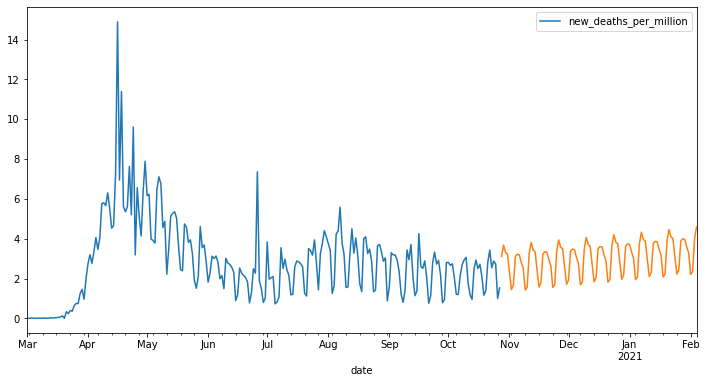

In [33]:

covid_model = ExponentialSmoothing(covid_df['new_deaths_per_million'],
                                  trend='add',
                                  seasonal='add',
                                  seasonal_periods=14).fit()
# Let's predict 100 days into the future
covid_forecast = covid_model.forecast(100)
# Print original and then our prediction
covid_df.plot(figsize=(12,6))
covid_forecast.plot()

## **ARIMA Model (Auto Regression)**
AutoRegressive Integrated Moving Average (ARIMA) is the basis for many other models. It focuses on trying to fit the data as well as possible by examining differences between values instead of the values themselves.

ARIMA works very well when data values have a clear trend and seasonality. We can only make predictions based on the data we have. Any outside effects not in the data can't be used to make predictions. For example we could make predictions on stock prices, but since we don't know when a recession may occur that event can't be modeled.

There is a seasonal (SARIMA) and a non-seasonal ARIMA. There is also SARIMAX which focuses on exogenous, or external factors. It differs from ARIMA in that it has a set of parameters (P, D, and Q) that focus on seasonality.

AR (Autoregressions) refers to a model that regresses based on prior values.

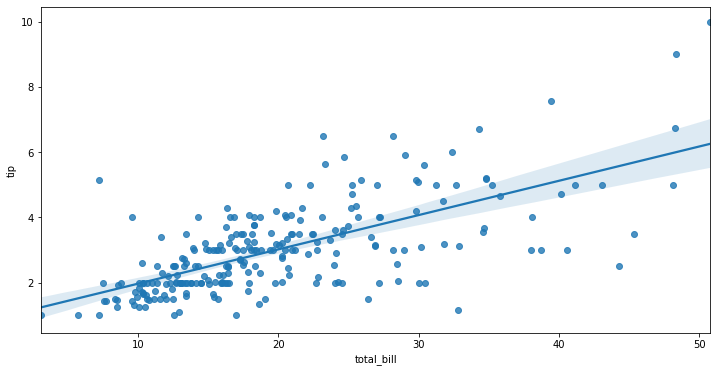

In [34]:
# Regression Example
# Our prediction is that as the bill amount increases
# so does the tip. Create a regression line to check
# Load tip dataset
tips = sns.load_dataset("tips")
# Create a regression line that averages the results
plt.figure(figsize=(12,6))
sns.regplot(x="total_bill", y="tip", data=tips)

In [35]:
#pip install statsmodels --upgrade

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/ar_model.py:252: FutureWarning:

The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/ar_model.py:252: FutureWarning:

The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 



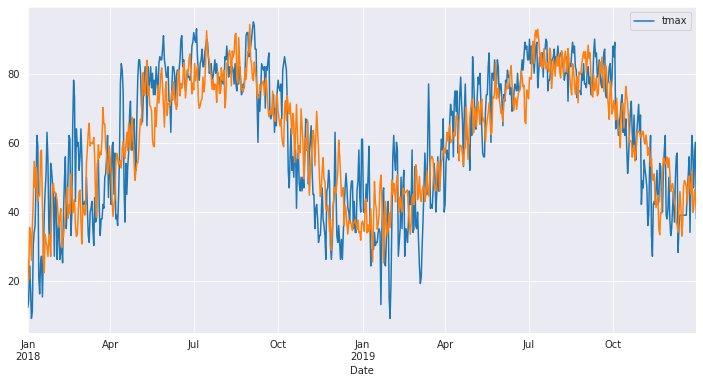

In [36]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.api import acf, pacf, graphics

pitt_df = pd.read_csv('https://raw.githubusercontent.com/derekbanas/TimeSeriesAnalysis/main/PittsburghWeather.csv', index_col='Date', parse_dates=True)
pitt_df = pitt_df.drop(['tmin', 'prcp'], axis=1)

# Get data since 2010
pitt_df = pitt_df[pitt_df.index>'2010-01-01']
pitt_df = pitt_df.asfreq('d') # Change frequency to day
pitt_df = pitt_df.fillna(method='ffill')
pitt_df.index # Check frequency
pitt_df.isnull().values.any() # Check for NaNs

# Set style for seaborn plot
sns.set_style('darkgrid')
# Add automatic datetime converters
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc('figure',figsize=(12, 6))

# Plot daily max temps
fig, ax = plt.subplots()
# ax = pitt_df.plot(ax=ax)

# Create our model using whole data set
model = AutoReg(pitt_df['tmax'], 30)
model_fit = model.fit()

# Define training and testing area
len(pitt_df) # 3651 observations
train_df = pitt_df.iloc[:2920] # 80%
test_df = pitt_df.iloc[2920:] # Last 20%

# Define training model for 730 days and White's covariance
# estimator
train_model = AutoReg(train_df['tmax'], 730).fit(cov_type="HC0")

start = len(train_df)
end = len(train_df) + len(test_df) - 1

prediction = train_model.predict(start=start, end=end, dynamic=True)

# Plot testing data with prediction
ax = test_df.plot(ax=ax)
ax = prediction.plot(ax=ax)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/ar_model.py:252: FutureWarning:

The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/ar_model.py:252: FutureWarning:

The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 



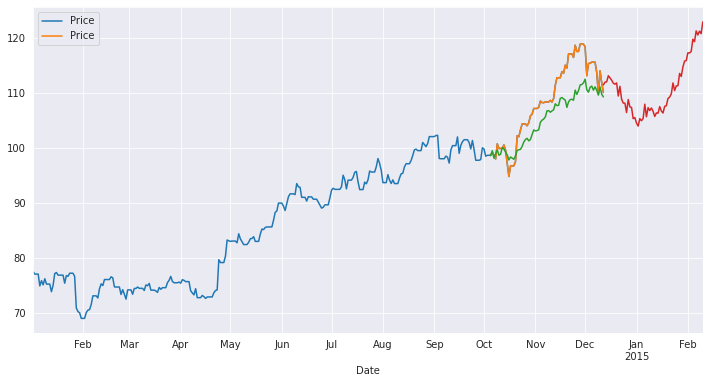

In [37]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

appl_df = pd.read_csv('https://raw.githubusercontent.com/derekbanas/TimeSeriesAnalysis/main/appl2.csv', index_col='Date', parse_dates=True)

appl_df = appl_df.asfreq('d') # Change frequency to day
appl_df = appl_df.fillna(method='ffill')
appl_df.index # Check frequency
appl_df.isnull().values.any() # Check for NaNs

# Set style for seaborn plot
sns.set_style('darkgrid')
# Add automatic datetime converters
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc('figure',figsize=(12, 6))

# Plot daily max temps
fig, ax = plt.subplots()
ax = appl_df.plot(ax=ax)

# Create our model using whole data set
model = AutoReg(appl_df['Price'], 30)
model_fit = model.fit()

# Define training and testing area
len(appl_df) # 345 observations
train_df = appl_df.iloc[:276] # 80%
test_df = appl_df.iloc[276:] # Last 20%

# Define training model for 100 days and White's covariance
# estimator
train_model = AutoReg(appl_df['Price'], 100).fit(cov_type="HC0")

# Define start and end for prediction 
start = len(train_df)
end = len(train_df) + len(test_df) - 1

prediction = train_model.predict(start=start, end=end, dynamic=True)

# Plot testing data with prediction
ax = test_df.plot(ax=ax) # Orange
ax = prediction.plot(ax=ax) # Green

# Predict 60 days into the future
forecast = train_model.predict(start=end, end=end+60, dynamic=True)
ax = forecast.plot(ax=ax) # Red

## **ARIMA (Integrated)**
I (Integrated) focuses on replacing values with the differences between previous values. Differencing is the computing of the differences between consecutive values. The goal is to make the time series stationary.

A stationary series has a constant mean and variance.

Dickey-Fuller Test
Test Statistic                -1.251942e+01
p-value                        2.568080e-23
#Lags Used                     3.300000e+01
Number of Observations Used    5.444000e+03
dtype: float64
Dickey-Fuller Test
Test Statistic                  -0.339865
p-value                          0.919665
#Lags Used                       0.000000
Number of Observations Used    239.000000
dtype: float64


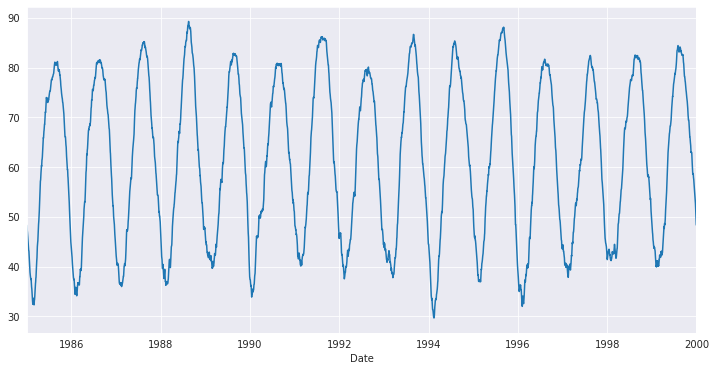

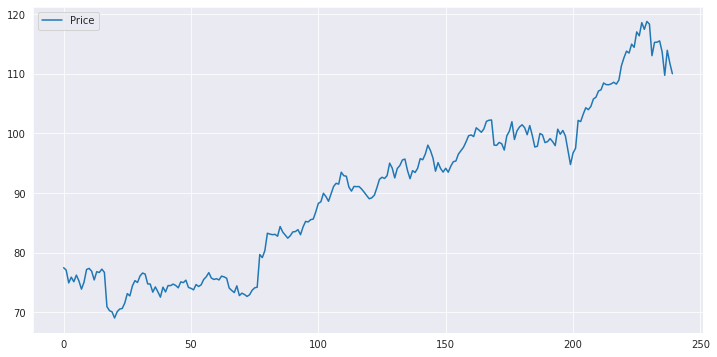

In [38]:
# Your data must be transformed to stationary form it to stationary
# form to be able to evaluate it

# Used to measure whether our data is stationary
from statsmodels.tsa.stattools import adfuller

# Stationary data is rather flat and the mean, variance 
# and autocorrelation structure do not change over time.
# This data isn't perfect because variance is changing
pitt_df = pd.read_csv('https://raw.githubusercontent.com/derekbanas/TimeSeriesAnalysis/main/PittsburghWeather.csv', 
                      index_col='Date', parse_dates=True)
# pitt_df['tmax'].plot(xlim=['1985-01-01','2000-01-01'])

# Flatten it out a bit by finding the mean
df_2 = pitt_df.rolling(window=60).mean()['tmax']
# Mask off dates and return them to the dataframe
mask = (df_2.index > '1985-01-01') & (df_2.index <= '2000-01-01')
df_2 = df_2.loc[mask]
df_2.plot()

# Example of non-stationary data US Birth rates 30-34
usbr_df = pd.read_csv('https://raw.githubusercontent.com/derekbanas/TimeSeriesAnalysis/main/US-Birth-Rates.csv', 
                      index_col='Year', parse_dates=True)
# usbr_df['30-34'].plot()

# Another non-stationary example
# Import stock data from a CSV file
df_appl = pd.read_csv('https://raw.githubusercontent.com/derekbanas/TimeSeriesAnalysis/main/appl2.csv')
df_appl.plot()

# The Augmented Dickey-Fuller Test tells us whether our results
# are stationary. If the P-Value is very small that means
# there is a very low probability that our reults are random
def adf_test(timeseries):
    print ('Dickey-Fuller Test')
    # AIC aims to minimize corresponding information
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    print (dfoutput)

# Highly stationary (Low P-Value)
adf_test(df_2)

# Not stationary (High P-Value)
adf_test(df_appl['Price'])

**Analyzing Time Series**

The Granger Causality test tells us if 1 time series can help us forecast the results in another.

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import dates
import mplfinance as mpf
%matplotlib inline
import statsmodels.api as sm
import seaborn as sns

import chart_studio.plotly as py
import plotly.express as px
import plotly.graph_objects as go

import cufflinks as cf # Connects Plotly to Pandas
# Makes Plotly work in your Notebook
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()

import requests # Get URL data
from bs4 import BeautifulSoup # Manipulate URL data
import json
from pandas import DataFrame as df


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4824  , p=0.4921  , df_denom=34, df_num=1
ssr based chi2 test:   chi2=0.5249  , p=0.4687  , df=1
likelihood ratio test: chi2=0.5212  , p=0.4703  , df=1
parameter F test:         F=0.4824  , p=0.4921  , df_denom=34, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.5387  , p=0.0953  , df_denom=31, df_num=2
ssr based chi2 test:   chi2=5.8964  , p=0.0524  , df=2
likelihood ratio test: chi2=5.4605  , p=0.0652  , df=2
parameter F test:         F=2.5387  , p=0.0953  , df_denom=31, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.1821  , p=0.0392  , df_denom=28, df_num=3
ssr based chi2 test:   chi2=11.9329 , p=0.0076  , df=3
likelihood ratio test: chi2=10.2680 , p=0.0164  , df=3
parameter F test:         F=3.1821  , p=0.0392  , df_denom=28, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.9832  , p=0.0043  , df_d

{1: ({'lrtest': (0.5212435236474846, 0.4703117117448017, 1),
   'params_ftest': (0.4823702925841984, 0.49206965338559716, 34.0, 1.0),
   'ssr_chi2test': (0.5249323772334225, 0.4687452204257758, 1),
   'ssr_ftest': (0.48237029259287467, 0.49206965338173014, 34.0, 1)},
   array([[0., 1., 0.]])]),
 2: ({'lrtest': (5.460543478315458, 0.06520156944103427, 2),
   'params_ftest': (2.5387421611477596, 0.09526742606055556, 31.0, 2.0),
   'ssr_chi2test': (5.896433406535575, 0.05243312644849383, 2),
   'ssr_ftest': (2.5387421611472614, 0.09526742606059639, 31.0, 2)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'lrtest': (10.267957654669686, 0.016420488807946155, 3),
   'params_ftest': (3.182098633453629, 0.03921153941086545, 28.0, 3.0),
   'ssr_chi2test': (11.932869875451955, 0.007616693590577782, 3),
   'ssr_ftest': (3.182098633453855, 0.03921153941085637, 28.0, 3)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0

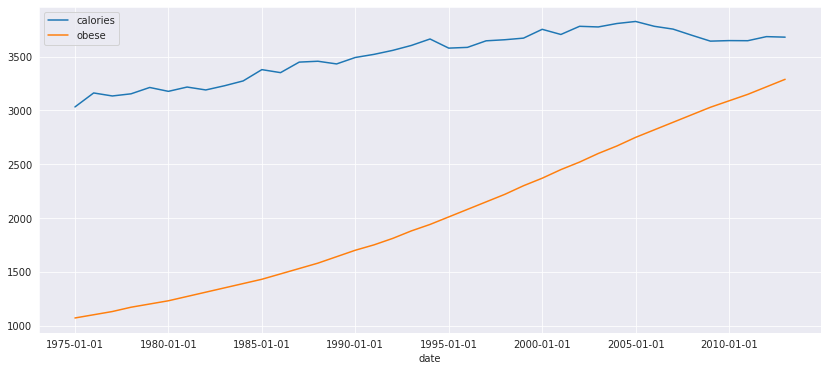

In [41]:
from statsmodels.tsa.stattools import grangercausalitytests

# function for the plotting
def plot_health_data(ax, csv, country, col, mult):
    cal_df = pd.read_csv(csv)
    indexer = cal_df[cal_df['location']==country].index
    country_df = cal_df.loc[indexer, 'date':col]
    # drop empty column
    country_df = country_df.dropna()
    country_df.set_index('date', inplace=True)
    country_df.drop(country_df.columns.difference([col]), 
                    1, inplace=True)
    country_df[col] = country_df[col] * mult
    ax = country_df.plot(ax=ax)
    
fig, ax = plt.subplots(figsize=(14,6))
plot_health_data(ax, 'https://raw.githubusercontent.com/derekbanas/TimeSeriesAnalysis/main/US-Daily-Calories.csv', 'United States',
                'calories', 1)
plot_health_data(ax, 'https://raw.githubusercontent.com/derekbanas/TimeSeriesAnalysis/main/US-Obese.csv', 'United States',
                'obese', 100)

cal_df = pd.read_csv('https://raw.githubusercontent.com/derekbanas/TimeSeriesAnalysis/main/US-Daily-Calories.csv')
obese_df = pd.read_csv('https://raw.githubusercontent.com/derekbanas/TimeSeriesAnalysis/main/US-Obese.csv')
new_df = pd.concat([cal_df, obese_df.obese], axis=1)
new_df

obese_diff = np.diff(new_df['obese'], n=1, axis=-1)
cal_diff = np.diff(new_df['calories'], n=1, axis=-1)
new_df = pd.concat([cal_df, pd.Series(obese_diff).rename('ObeseDiff')],
                  axis=1)
new_df = pd.concat([new_df, pd.Series(cal_diff).rename('CalDiff')],
                  axis=1)
new_df = new_df.dropna()
new_df
grangercausalitytests(new_df[['ObeseDiff', 'CalDiff']], maxlag=4)

**MeanABS MSE, and RMSE**

Mean Absolute Error : Difference between Prediction and Result and find Average

Mean Squared Error : Takes the difference to Find Mean, but Errors Show Dramatically

Root Mean Squared Error : Finding the Square Root Returns to the Original Unit

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 250 entries, 2020-03-01 to 2020-11-05
Freq: D
Data columns (total 1 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   new_deaths_per_million  250 non-null    float64
dtypes: float64(1)
memory usage: 3.9 KB


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning:

After 0.13 initialization must be handled at model creation



1.3723805225015635

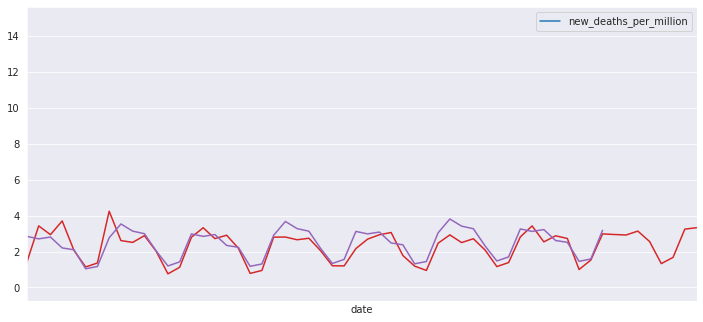

In [47]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tools.eval_measures import mse, rmse, meanabs

owid_df = pd.read_csv("https://raw.githubusercontent.com/derekbanas/TimeSeriesAnalysis/main/owid-covid-data-11-5.csv")

owid_df.columns # Show all columns

# Create Numpy array of unique countries
covid_df = owid_df.location.unique()
# Get indexes for United States
indexer = owid_df[owid_df['location']=='United States'].index
# Get dataframe location and column data for country name
covid_df = owid_df.loc[indexer, 'date':'new_deaths_per_million']
# Delete NaN values
covid_df = covid_df.dropna()
# Set date as index
covid_df.set_index('date', inplace=True)
# Remove all columns except for what I want
covid_df.drop(covid_df.columns.difference(['new_deaths_per_million']), 1, inplace=True)
covid_df.plot(figsize=(12,6))
# Plot a 30 day moving average
covid_df.rolling(window=30).mean()['new_deaths_per_million'].plot()

covid_df = covid_df.asfreq('d') # Set frequency for daily
# covid_df = covid_df.set_index('date').asfreq('d')
# Get the number of data points we have
covid_df.info() # 241 : 192 Training : 49 Test
# Separate into 2 pieces
train_df = covid_df.iloc[:192]
test_df = covid_df.iloc[191:]

# There is no exponential growth so I'll use additive
# I picked 14 for period because it provided the best result
fit_model = ExponentialSmoothing(train_df['new_deaths_per_million'],
                                  trend='add',
                                  seasonal='add',
                                  seasonal_periods=14).fit()
# We can now make predictions 50 days into the future
prediction = fit_model.forecast(50)
prediction

# Plot training, testing and projection data
train_df['new_deaths_per_million'].plot(figsize=(12,6))
test_df['new_deaths_per_million'].plot()
prediction.plot(xlim=['2020-09-09','2020-11-05'])

rmse(test_df, prediction, axis=None)
meanabs(test_df, prediction, axis=None)
mse(test_df, prediction, axis=None)

Testing for Seasonality

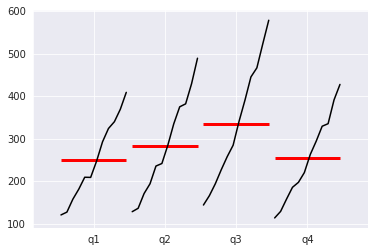

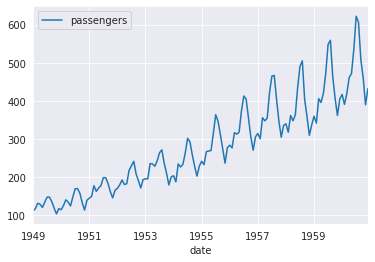

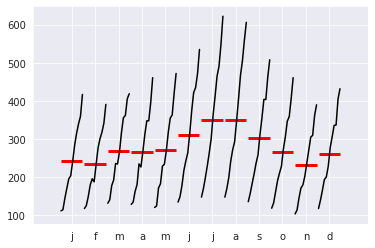

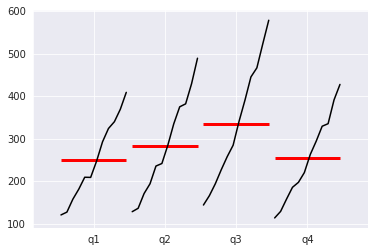

In [49]:

from statsmodels.graphics.tsaplots import month_plot, quarter_plot

flight_df = sns.load_dataset('flights')
flight_df['day'] = '01'
flight_df['month'] = pd.to_datetime(flight_df.month, format='%b').dt.month
flight_df['date'] = pd.to_datetime(flight_df[['year', 'month', 'day']])
flight_df.drop('year', axis=1, inplace=True)
flight_df.drop('month', axis=1, inplace=True)
flight_df.drop('day', axis=1, inplace=True)
flight_df.set_index('date', inplace=True)
flight_df.index.freq = 'MS'
flight_df.index
flight_df.plot()

month_plot(flight_df['passengers'])

f_qtr_df = flight_df['passengers'].resample(rule='Q').mean()
quarter_plot(f_qtr_df)

In [50]:
from statsmodels.tsa.stattools import grangercausalitytests

# Receives ax for plotting, csv file, country, column of interest
def plot_covid_data(ax, csv, country, col):
    cal_df = pd.read_csv(csv)
    indexer = cal_df[cal_df['location']==country].index
    country_df = cal_df.loc[indexer, 'date':col]
    country_df = country_df.dropna()

    country_df.set_index('date', inplace=True)
    country_df.drop(country_df.columns.difference([col]), 1, inplace=True)

    ax = country_df.plot(ax=ax)

# Does lowering lockdown strategy cause the number of new cases to rise?


## **ARIMA Model : Finding P, D and Q**

As we saw the AR stands for AutoRegression, which focuses on making predictions on future values based on passed values.

**Integration** focuses on replacing values with the differences between previous values. Differencing is the computing of the differences between consecutive values. The goal is to make the time series stationary.

**Moving Average** focuses on correcting regression errors over time. A moving average is just the smoothed out real values and it is created by removing noise in the data.

Non-seasonal ARIMA models have 3 parameters. Number of time lags of the AR model p, how many times we have to difference the data d and q represents the order of the MA model.

We have to decide if we need to difference our data and it is also common to only use AR or MA.

If your autocorrelation plot has a positive autocorrelation at lag 1 you should use AR. If it is negative you should use MA.

* **AR** : AutoRegression
* **Integration** : Replacing with the Differences
* **Moving Average** : Correcting Regression Errors over time
* **Non-seasonal** ARIMA Models

  * **p** : Number of time lags of the AR Model
  * **d** : How many times we have to difference the data
  * **q** : Represents the order of the MA model
* USE AR or MA? 


## **Analyzing Weather Data Monthly**

Dickey-Fuller Test
Test Statistic                -6.013137e+00
p-value                        1.556204e-07
#Lags Used                     1.800000e+01
Number of Observations Used    4.610000e+02
dtype: float64


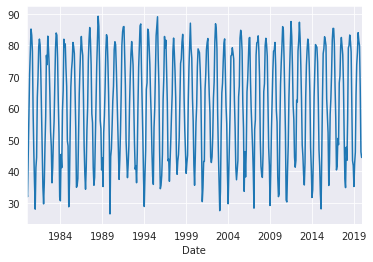

In [51]:
pitt_df = pd.read_csv('https://raw.githubusercontent.com/derekbanas/TimeSeriesAnalysis/main/PittsburghWeather.csv', index_col='Date', parse_dates=True)
pitt_df = pitt_df.drop(['tmin', 'prcp'], axis=1)

# Get data since 1980
pitt_df = pitt_df[pitt_df.index>'1980-01-01']
pitt_df = pitt_df.asfreq('d') # Change frequency to day
pitt_df = pitt_df.fillna(method='ffill')
pitt_df.index # Check frequency

# Resample data using month instead of day
pitt_df = pitt_df['tmax'].resample(rule='MS').mean()
pitt_df.plot()

# The Augmented Dickey-Fuller Test tells us whether our results
# are stationary. If the P-Value is under .05 that means
# there is a very low probability that our results are random
def adf_test(timeseries):
    print ('Dickey-Fuller Test')
    # AIC aims to minimize corresponding information
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    print (dfoutput)

# Highly stationary (Low P-Value)
adf_test(pitt_df)

## **Auto Correlation Function**

Used to identify a MA model.

Auto Regressive Integrated Moving Average (ARIMA) based models forecast a time series based on past data and forecast errors.

The ACF and PACF provide parameters for ARIMA models.

2 groups of data that move in like ways are said to be correlated. Correlation is measured between the values of -1 (Inverse Correlation) to 0 (No Relationship) to 1 (Strongly Correlated).

With auto correlation we compare data to itself shifted a defined amount of time. For example we could shift a week and determine if last weeks performance is correlated to this week.

With auto correlation the y access is the correlation and x is the time shift amount. This way we can see how well our data is correlated over time.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:660: FutureWarning:

The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.



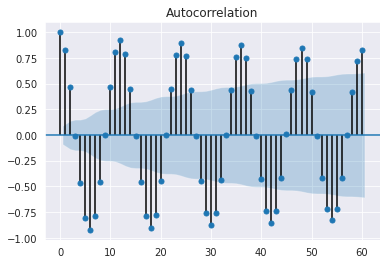

In [52]:
from statsmodels.tsa.stattools import acovf, acf
from statsmodels.graphics.tsaplots import plot_acf

acf(pitt_df, fft=False)

# Squeeze squeezes single column dataframes to a series
# Lag defines how much we want to shift the data
# The area shadded in blue is very likely to be in correlation
# That means they line up well with a regression line (Average)
# The blue area represents 95% of the correlated data
sm.graphics.tsa.plot_acf(pitt_df.values.squeeze(), lags=60);


## **Partial Auto Correlation Function**
Used to identify an AR model. If there is a gradual decline that suggests that we use an MA model.

An auto correlation has both a direct and indirect correlation. The PAC tries to remove those indirect correlations. With it we look for the difference between our linear model and the actual results. This difference is called the residual. We then plot those residuals. This works best with data that tends to be stationary.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:995: FutureWarning:

ywunbiased has been renamed ywadjusted. After release 0.13, using the old name will raise.



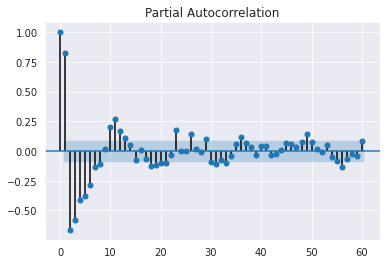

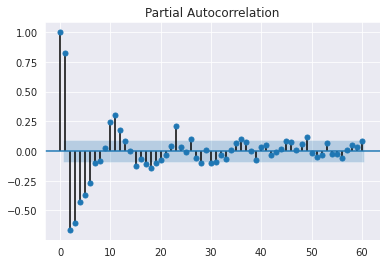

In [53]:
from statsmodels.graphics.tsaplots import plot_pacf

# There are different ways to measure correlation and 
# different ways of measuring partial auto correlation
# Also ywm, ldunbiased, ldbiased (Levinson-Durbin recursion)
sm.graphics.tsa.plot_pacf(pitt_df.values.squeeze(), lags=60,
                          method='ywunbiased');

sm.graphics.tsa.plot_pacf(pitt_df.values.squeeze(), lags=60,
                         method='ols');

# Non-recursive yule_walker
# Steps through the data and removes that weighting that effects
# all the data
# pacf_yw(pitt_df);

# OLS Ordinary Least Squares : Estimates the data so a line can 
# be drawn through data points
# pacf_ols(pitt_df);


## **Grid Search**

Often reading the ACF and PACF plots can be difficult. In those situations it is better to perform a Grid Search. A Grid Search tests numerous combinations of the p, d and q values to see which perform best.

The Pyramid ARIMA library is used to perform grid searches. It wil tell you if you should use an ARIMA or Seasonal ARIMA model. The Pyramid library uses the Akaike Information Criterion (AIC) to compare the performance.

## **Akaike Information Criterion (AIC)**

Akaike Information Criterion (AIC) analyzes multiple models and makes estimates on the quality of each model in relation to them. AIC aims to find the simpliest model that represents what we are studying even if a much more complex model performs slightly better. It does this by penalizying for using a large number of parameters. When referring to AIC we often talk about overfitted models. These are models that perform well during the training phase, but not during forecasting.

Bayesian Information Criterion (BIC) is similar to AIC aside from being different mathematically.

### **Pyramid ARIMA**

In [55]:
!pip install pmdarima

     |████████████████████████████████| 1.5MB 6.0MB/s 
     |████████████████████████████████| 2.1MB 36.5MB/s 
     |████████████████████████████████| 8.7MB 43.0MB/s 
     |████████████████████████████████| 808kB 44.3MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21
  Found existing installation: statsmodels 0.12.1
    Uninstalling statsmodels-0.12.1:
      Successfully uninstalled statsmodels-0.12.1
  Found existing installation: setuptools 50.3.2
    Uninstalling setuptools-50.3.2:
      Successfully uninstalled setuptools-50.3.2


In [56]:
# Install in your terminal or command line
from pmdarima import auto_arima
# help(auto_arima) Get info on parameters

# Turn off warnings that can be distracting and of no concern
import warnings
warnings.filterwarnings('ignore')

# start_p = 0 assumes there is no AR component
# start_q = 0 also to suggest no order for MA
# Define we are searching for 24 different models 6 * 4
# Seasonal is set to False since it is stationary
# Trace shows the 1st couple ARIMA models it tried to fit
step_fit = auto_arima(pitt_df, start_p=0, start_q=0, 
                      max_p=5, max_q=3, 
                      seasonal=False, trace=True)

# Returns AIC and BIC which estimate the quality of the models
# Then summary provides the best performing model
step_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5347.862, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=3581.108, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=4761.543, Time=0.15 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=3425.661, Time=0.08 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=3417.572, Time=0.11 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=3363.796, Time=0.16 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=3276.687, Time=0.22 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.99 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=3073.717, Time=1.00 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=3407.840, Time=0.18 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=2868.061, Time=1.01 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=1.11 sec
 ARIMA(5,0,2)(0,0,0)[0]             : AIC=inf, Time=1.47 sec
 ARIMA(4,0,3)(0,0,0)[0]             : AIC=inf, Time=1.35 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=3097.543, T

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  480
Model:               SARIMAX(4, 0, 2)   Log Likelihood               -1427.031
Date:                Sun, 15 Nov 2020   AIC                           2868.061
Time:                        02:22:34   BIC                           2897.278
Sample:                             0   HQIC                          2879.546
                                - 480                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.2912      0.037     61.328      0.000       2.218       2.364
ar.L2         -1.5323      0.101    -15.127      0.000      -1.731      -1.334
ar.L3         -0.1929      0.101     -1.905      0.057      -0.391       0.006
ar.L4          0.4340      0.037     11.627      0.000       0.361       0.507
ma.L1         -1.7702      0.022    -79.240      0.000      -1.814      -1.726
ma.L2          0.9148      0.022     42.221      0.000       0.872       0.957
sigma2        21.6656      1.374     15.769      0.000      18.973      24.358
===================================================================================
Ljung-Box (L1) (Q):                   3.61   Jarque-Bera (JB):                 2.53
Prob(Q):                              0.06   Prob(JB):                         0.28
Heteroskedasticity (H):               1.35   Skew:                             0.10
Prob(H) (two-sided):                  0.06   Kurtosis:                         3.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### **ARIMA and Non-Stationary Data**

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1032.128, Time=0.30 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1031.508, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1020.393, Time=0.14 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1021.003, Time=0.23 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1020.393, Time=0.05 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1019.239, Time=0.41 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=2.93 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=1020.493, Time=0.47 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1032.120, Time=0.25 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1021.120, Time=0.51 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=1021.032, Time=0.69 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=1019.178, Time=0.42 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1020.425, Time=0.14 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=inf, Time=2.59 sec
 ARIMA(0,1,1)(1,1,1)[12]     

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(2, 1, [], 12)   Log Likelihood                -505.589
Date:                             Sun, 15 Nov 2020   AIC                           1019.178
Time:                                     02:23:18   BIC                           1030.679
Sample:                                          0   HQIC                          1023.851
                                             - 144                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3634      0.074     -4.945      0.000      -0.508      -0.219
ar.S.L12      -0.1239      0.090     -1.372      0.170      -0.301       0.053
ar.S.L24       0.1911      0.107      1.783      0.075      -0.019       0.401
sigma2       130.4480     15.527      8.402      0.000     100.016     160.880
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 4.59
Prob(Q):                              0.92   Prob(JB):                         0.10
Heteroskedasticity (H):               2.70   Skew:                             0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

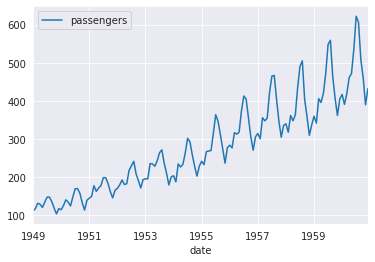

In [58]:
flight_df = sns.load_dataset('flights')
flight_df['day'] = '01'
flight_df['month'] = pd.to_datetime(flight_df.month, format='%b').dt.month
flight_df['date'] = pd.to_datetime(flight_df[['year', 'month', 'day']])
flight_df.drop('year', axis=1, inplace=True)
flight_df.drop('month', axis=1, inplace=True)
flight_df.drop('day', axis=1, inplace=True)
flight_df.set_index('date', inplace=True)
flight_df.index.freq = 'MS'
flight_df.plot()

# This time seasonal is set to True
# m is the number of periods per season 4 quarterly,
# 12 monthly, etc.
step_fit2 = auto_arima(flight_df['passengers'], 
                       start_p=0, start_q=0, max_p=5, max_q=3, 
                       seasonal=True, trace=True, m=12)

step_fit2.summary()

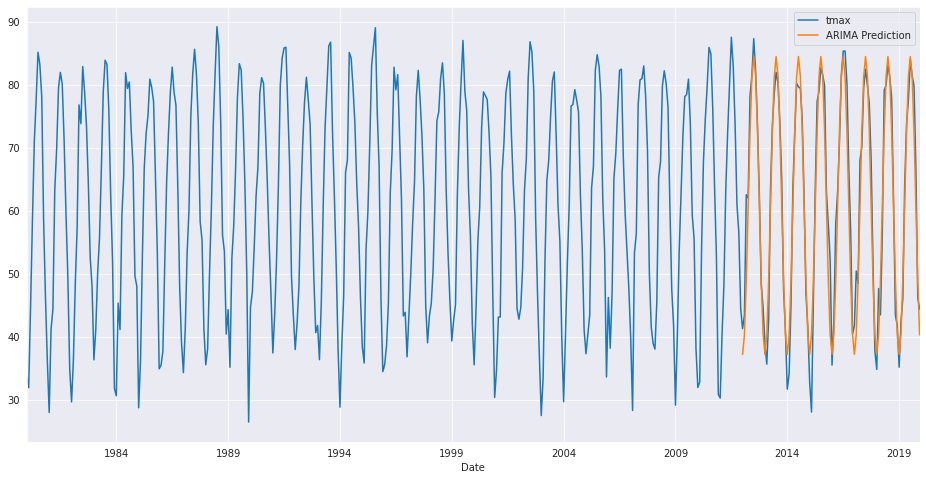

In [59]:
## Make prediction to ARIMA


# Write dataframe to csv
# pitt_df.to_csv('Pitt-M-Temp-80-pres.csv')

p_df = pd.read_csv('https://raw.githubusercontent.com/derekbanas/TimeSeriesAnalysis/main/Pitt-M-Temp-80-pres.csv', index_col='Date', parse_dates=True)

from statsmodels.tsa.arima_model import ARIMA, ARMA, ARIMAResults, ARMAResults
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# pip install pmdarima
from pmdarima import auto_arima

# Seasonal Data
# p_df.plot()

# Tells us what model to use
# ARIMA(2,0,2)(0,0,0)
# auto_arima(p_df, seasonal=True, trace=True).summary() 
# Split the data into a training and testing set
p_df.size # 480
train_df = p_df.iloc[:384] # 80%
test_df = p_df.iloc[384:] # 20%

# Create the model
mod = ARIMA(train_df, order=(2,0,2))
# Fit the model to get the results
res = mod.fit()
# Get the summarized forcast which is the same as auto_arima
res.summary()

# Get predicted values
start = len(train_df)
end = len(train_df) + len(test_df) - 1
prediction = res.predict(start, end).rename('ARIMA Prediction')

# Plot Prediction
p_df.plot(figsize=(16,8), legend=True)
prediction.plot(legend=True)

## **Stationarity**
**Definition** A stationary data set does not change the way it changes over time. Basically it has a constant slope or rate of change.

**Why Use Them** They are easy to analyze and they are required often during time series analysis.

Mean 1 : tmax    60.862379
dtype: float64
Mean 2 : tmax    61.27377
dtype: float64
Variance 1 : tmax    291.969897
dtype: float64
Variance 2 : tmax    294.172683
dtype: float64
Dickey-Fuller Test
Test Statistic                -6.013137e+00
p-value                        1.556204e-07
#Lags Used                     1.800000e+01
Number of Observations Used    4.610000e+02
dtype: float64
Dickey-Fuller Test
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
dtype: float64


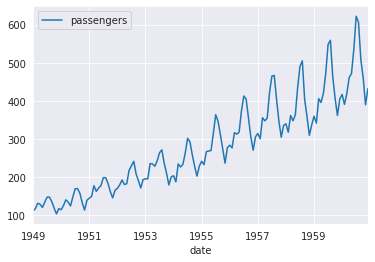

In [60]:

# For a dataset to be stationary the data must have a constant
# mean and variance. We can test this by spliting the data
# and testing mean and variance.
d_set = p_df
# Get midpoint
split = round(len(d_set) / 2)
# Split into 2 datasets at midpoint
d_set1 = d_set[:split]
d_set2 = d_set[split:]
print("Mean 1 :", d_set1.mean())
print("Mean 2 :", d_set2.mean())
print("Variance 1 :", d_set1.var())
print("Variance 2 :", d_set2.var())

# This Dickey Fuller test from before shows I have a Test
# Statistic of -6. The more negative this value is the more
# likely the data is stationary. 
adf_test(p_df)
# Our sample size is 480. A Dickey-Fuller look-up table 
# at sample size 500 says that we can be certain 95% that 
# our data is stationary if the test statistic is less
# than -3.98 in all situations. 
p_df.size

# Our flight data in comparison has a high test statistic and
# a P-Value over 0.05 which shows it isn't stationary
flight_df.plot()
adf_test(flight_df)

Dickey-Fuller Test
Test Statistic                -1.036431e+01
p-value                        2.352014e-18
#Lags Used                     1.300000e+01
Number of Observations Used    4.650000e+02
dtype: float64
Dickey-Fuller Test
Test Statistic                  -2.829267
p-value                          0.054213
#Lags Used                      12.000000
Number of Observations Used    130.000000
dtype: float64


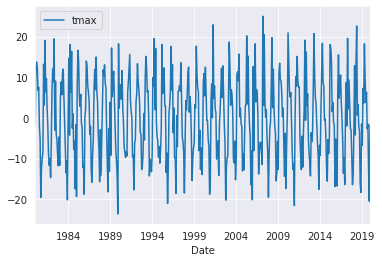

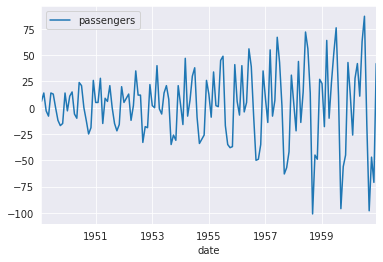

In [61]:
# Use Pandas to difference the dataframe and make the data 
# stationary
diff_df = p_df.diff().dropna()
diff_df.plot()
adf_test(diff_df)

# If we do the same with our flight data we get a stationary
# mean, but not a stationary variance
diff2_df = flight_df.diff().dropna()
diff2_df.plot()
adf_test(diff2_df)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=3374.468, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5347.862, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=3581.108, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=4761.543, Time=0.13 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=3407.714, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=3423.529, Time=0.14 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=1.08 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=3357.634, Time=0.43 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=3377.559, Time=0.28 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=2986.285, Time=0.84 sec
 ARIMA(4,0,3)(0,0,0)[0]             : AIC=inf, Time=1.31 sec
 ARIMA(3,0,4)(0,0,0)[0]             : AIC=2805.964, Time=0.99 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=inf, Time=0.95 sec
 ARIMA(4,0,4)(0,0,0)[0]             : AIC=inf, Time=1.80 sec
 ARIMA(3,0,5)(0,0,0)[0]             : AIC=2741.058, T

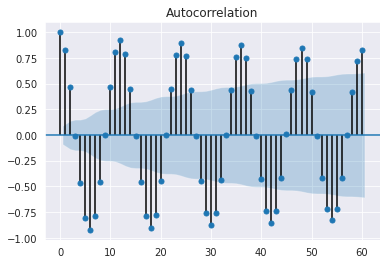

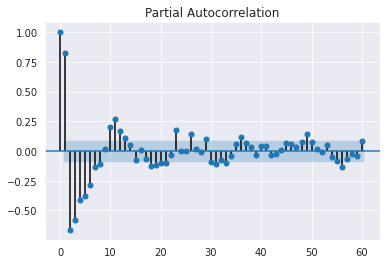

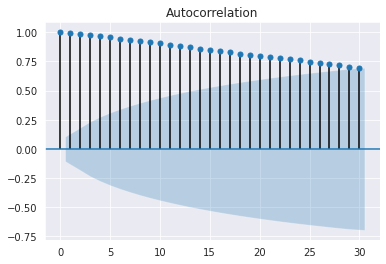

In [62]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Check to see seasonal component
res = seasonal_decompose(p_df, model='add')
# res.plot();

# Even though I tell it it isn't seasonal it overrides me
# If I don't use trace. Otherwise ARIMA(4,0,5)
auto_arima(p_df, seasonal=False, trace=True).summary()

# How is Integration determined? If we run Dickey Fuller on
# the undifferenced data we see that the P-Value is under 
# 0.05 so there is no reason to difference it
adf_test(p_df)

# How do we determine which is more significant AR or MA?
# If PACF has a sharp cutoff then add AR to the model. There
# are between 2 to 5 cutoffs so you should test for the values
# of AR for 2 and 5 which is what auto_arima does.
 
plot_acf(p_df, lags=60);
plot_pacf(p_df, lags=60);

# How do we find the MA value? If there was a slow decline like we
# see with this Apple price data it is suggested that we us AR
# over MA, but that isn't true with our temperature data. That
# implies that we need to test for MA values greater than AR.
# There is a lot of guessing here which is why we use auto_arima
plot_acf(appl_df, lags=30);

## **Seasonal Autoregressive Integrated Moving Average**
We were trying to force seasonal data which is why we were getting imperfect results. With SARIMA we use an additional set of parameters that describe seasonal components of our model (P,D,Q)m.

* P : Seasonal Regression
* D : Differencing
* Q : Moving Average
* m : Rows in Each Season Cycle
With monthly data with a yearly seasonal cycle m would equal 12.

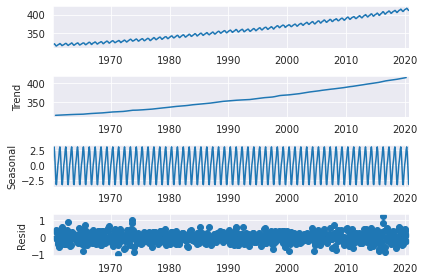

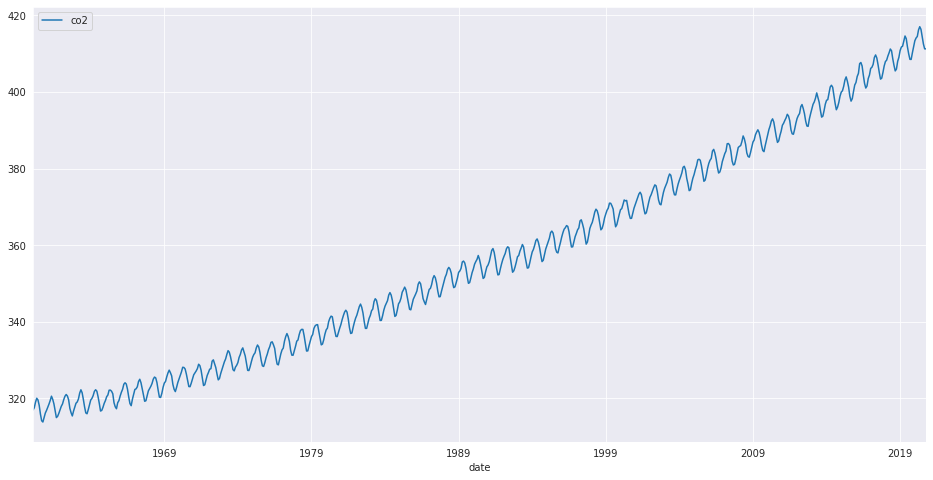

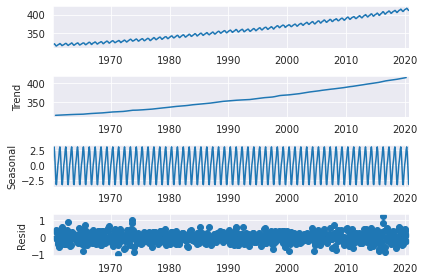

In [63]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose

co2_df = pd.read_csv('https://raw.githubusercontent.com/derekbanas/TimeSeriesAnalysis/main/co2_data.csv', index_col='date', parse_dates=True)

# Monthly global CO2 data since 1960
co2_df = co2_df[co2_df.index>'1960-01-01']
co2_df = co2_df.asfreq('MS') # Change frequency to month
co2_df = co2_df.fillna(method='ffill')
co2_df.plot(figsize=(16,8))

# We verify that there is a seasonal component
res = seasonal_decompose(co2_df, model='add')
res.plot()

In [64]:
# Run auto_arima as seasonal with m since the season occurs 
# over 12 months
auto_arima(co2_df, seasonal=True, m=12, trace=True).summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=428.601, Time=4.31 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2378.581, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=1.27 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1613.443, Time=0.78 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2384.532, Time=0.03 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=1102.245, Time=3.77 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=757.059, Time=3.75 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=433.553, Time=13.12 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=490.077, Time=11.89 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=1445.407, Time=1.04 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=inf, Time=10.73 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=587.673, Time=11.39 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=inf, Time=12.45 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=424.265, Time=2.89 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  729
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -196.643
Date:                            Sun, 15 Nov 2020   AIC                            403.286
Time:                                    02:52:04   BIC                            426.237
Sample:                                         0   HQIC                           412.142
                                            - 729                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2115      0.079      2.672      0.008       0.056       0.367
ma.L1         -0.5574      0.068     -8.144      0.000      -0.692      -0.423
ar.S.L12       0.9997      0.000   4026.297      0.000       0.999       1.000
ma.S.L12      -0.8640      0.022    -40.105      0.000      -0.906      -0.822
sigma2         0.0930      0.004     21.142      0.000       0.084       0.102
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):                 4.56
Prob(Q):                              0.67   Prob(JB):                         0.10
Heteroskedasticity (H):               1.18   Skew:                            -0.02
Prob(H) (two-sided):                  0.20   Kurtosis:                         3.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

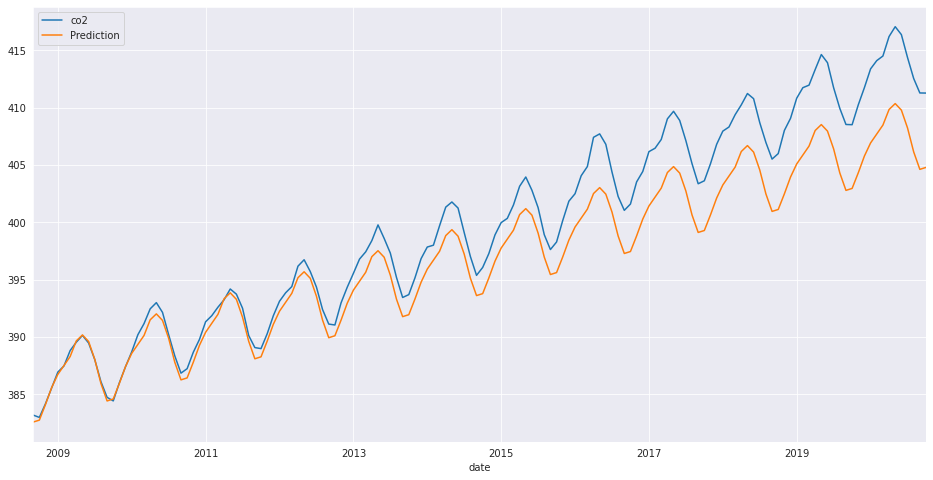

In [65]:
# SARIMAX(0, 1, 3)x(1, 0, [1], 12)

len(co2_df) # 729

train_df = co2_df.iloc[:583] # 80%
test_df = co2_df.iloc[583:] # 20%

# Parameters include the dataset, the 1st order for ARIMA,
# the seasonal order
model = SARIMAX(train_df, order=(0, 1, 3),
               seasonal_order=(1, 0, 1, 12))
res = model.fit()
# Get prediction for test set
start = len(train_df)
end = len(train_df) + len(test_df) - 1
# type typ : levels - Predict original endogenous variables
# linear : Linear prediction
prediction = res.predict(start, end, 
                         typ='linear').rename('Prediction')
test_df.plot(legend=True, figsize=(16,8))
prediction.plot(legend=True)

In [66]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# The prediction is pretty good being that the mean is 356.8 
# and the error was 3.43
co2_df.mean() # 356.8
np.sqrt(mean_squared_error(test_df, prediction)) # Off by 3.43

3.405712460760771

In [ ]:
# Predict CO2 levels 1 year into the future
model = SARIMAX(co2_df, order=(0, 1, 3),
               seasonal_order=(1, 0, 1, 12))
res = model.fit()
future = res.predict(len(co2_df), len(co2_df)+12, 
                    typ='levels').rename('Future')
test_df.plot(legend=True, figsize=(16,8))
future.plot(legend=True)


## **SARIMAX**
SARIMAX supports exogenous regressor variables. Endogenous Variables are dependent on many outside influences. For example the cost of a tomato is based on weather, pests, cost of fuel, etc.

Exogenous Variables are not effected by outside influences and are fixed in the model. An example of an Exogenous piece of data is used in this video with a holidays effet on the price of oil. A holiday is a unique date, but it happens at exactly the same time, pretty much, every single year.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

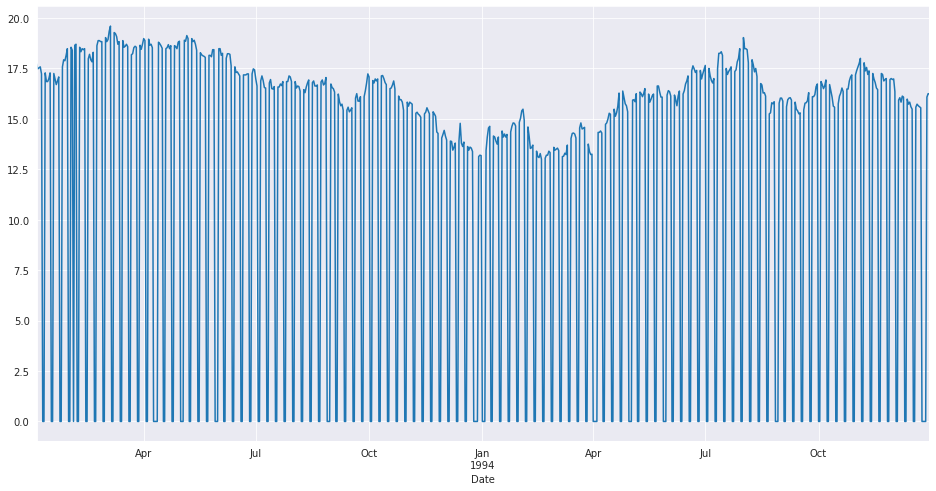

In [73]:

oil_df = pd.read_csv('/content/drive/My Drive/brent-daily_csv.csv', 
                     index_col='Date', parse_dates=True)
# Data up till 1995
oil_df = oil_df[(oil_df.index>'1993-01-01') & (oil_df.index<'1995-01-01')]

oil_df = oil_df.asfreq('D') # Change frequency to day
# Fill missing holiday colun with zeroes
oil_df['Price'] = oil_df['Price'].fillna(0)
# Fill price column with what preceeded
oil_df = oil_df.fillna(method='ffill')

# oil_df['price'].plot(figsize=(16,8))

fig, ax = plt.subplots(figsize=(16,8))
ax = oil_df['Price'].plot();

# Get index columns where holiday == 1
# Easter(4), Memorial Day(5), Independence Day(7), Labor Day(9), Thanksgiving(11), 
# Christmas(12)
# Easter & Memorial Day and Thanksgiving & Christmas are dark lines
# Draw colored lines every place there is a holiday
color_arr = ['g', 'r', 'm', 'b', 'y', 'k']
c_indx = 0
for x in oil_df[oil_df['Price']==1].index:
    ax.axvline(x=x, color=color_arr[c_indx], linewidth=0.5);
    if color_arr[c_indx] == 'k':
        c_indx = 0
    else:
        c_indx += 1

In [76]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose

# Is there a seasonal component
res = seasonal_decompose(oil_df['Price'])
# res.plot();

# Show just the seasonal component
# res.seasonal.plot(figsize=(16,8))
auto_arima(oil_df['Price'], m=7, trace=True).summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=3.81 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=5223.795, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=4045.869, Time=0.71 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=inf, Time=1.39 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=5221.795, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=5225.764, Time=0.09 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=inf, Time=1.44 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=3684.413, Time=1.61 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=4768.517, Time=0.40 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=3686.334, Time=3.76 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=3686.325, Time=3.43 sec
 ARIMA(1,1,0)(0,0,2)[7] intercept   : AIC=4499.437, Time=0.94 sec
 ARIMA(1,1,0)(2,0,2)[7] intercept   : AIC=inf, Time=3.38 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=1.30 sec
 ARIMA(2,1,0)(1,0,1)[7] intercept   : AIC=3557.387, Time=2

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  726
Model:             SARIMAX(3, 1, 0)x(2, 0, [1], 7)   Log Likelihood                 -26.539
Date:                             Sun, 15 Nov 2020   AIC                             69.079
Time:                                     03:03:27   BIC                            105.768
Sample:                                          0   HQIC                            83.238
                                             - 726                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1938   5.93e-09   3.27e+07      0.000       0.194       0.194
ar.L1          2.9873   5.17e-08   5.77e+07      0.000       2.987       2.987
ar.L2         -2.9836   5.44e-08  -5.49e+07      0.000      -2.984      -2.984
ar.L3          0.9963   1.22e-08   8.18e+07      0.000       0.996       0.996
ar.S.L7        0.0102   9.83e-10   1.04e+07      0.000       0.010       0.010
ar.S.L14       0.9897   3.57e-08   2.77e+07      0.000       0.990       0.990
ma.S.L7        0.6963   1.58e-08   4.41e+07      0.000       0.696       0.696
sigma2       269.3809   2.38e-06   1.13e+08      0.000     269.381     269.381
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):          15747139.30
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.00   Skew:                           -26.87
Prob(H) (two-sided):                  0.00   Kurtosis:                       723.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

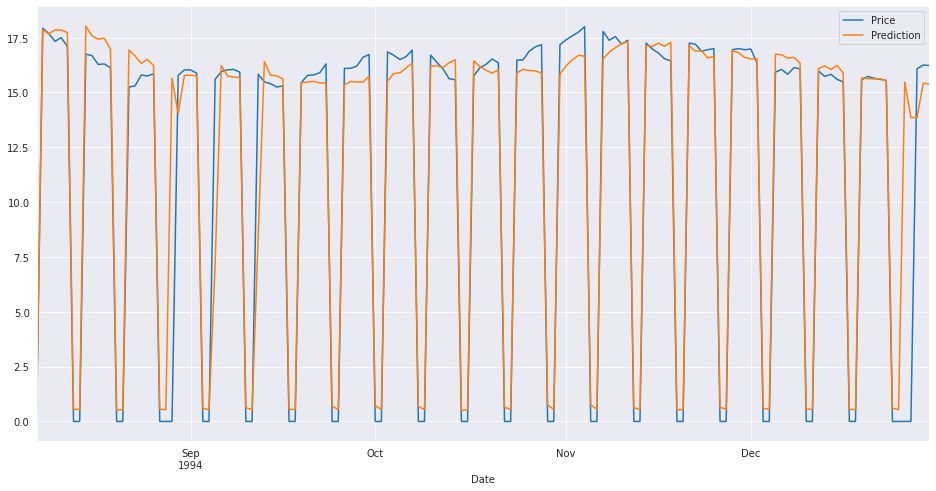

In [79]:
len(oil_df) # 726
train_df = oil_df.iloc[:580] # 80%
test_df = oil_df.iloc[580:]

mod = SARIMAX(oil_df['Price'], order=(1,1,1), seasonal_order=(2,0,0,7))
res = mod.fit()
# res.summary()
start = len(train_df)
end = len(train_df) + len(test_df) - 1
prediction = res.predict(start, end).rename('Prediction')
ax = test_df['Price'].plot(legend=True, figsize=(16,8))
prediction.plot(legend=True)

# Check if the holiday had any effect on oil prices
color_arr = ['g', 'r', 'm', 'b', 'y', 'k']
c_indx = 0
for x in oil_df[oil_df['Price']==1].index:
    ax.axvline(x=x, color=color_arr[c_indx], linewidth=0.5);
    if color_arr[c_indx] == 'k':
        c_indx = 0
    else:
        c_indx += 1

In [80]:
# We must know when holidays will fall into the future because we can't
# predict the future prices and the holidays
# How did we perform and does adding holiday data improve it?
rmse(test_df['Price'], prediction)

# Train now with the holiday data
auto_arima(oil_df['Price'], exogenous=oil_df[['Price']], seasonal=True, 
          m=7, trace=True).summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=-15335.514, Time=15.94 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=-15334.093, Time=0.20 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=-15342.334, Time=5.51 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=-15330.043, Time=16.52 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=-15336.093, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=-15332.104, Time=0.21 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=inf, Time=8.92 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=-15325.427, Time=5.40 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=-15329.992, Time=14.55 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=-1401.878, Time=3.14 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=-15344.169, Time=3.73 sec
 ARIMA(0,1,0)(2,0,0)[7] intercept   : AIC=inf, Time=10.76 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=-15327.345, Time=5.72 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=-15331.983, Time=12.93 sec
 ARIMA(0,1,0)(2

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  726
Model:             SARIMAX(0, 1, 0)x(1, 0, 0, 7)   Log Likelihood                7676.230
Date:                           Sun, 15 Nov 2020   AIC                         -15346.459
Time:                                   03:06:42   BIC                         -15332.701
Sample:                               01-04-1993   HQIC                        -15341.150
                                    - 12-30-1994                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Price          1.0000   1.22e-07   8.19e+06      0.000       1.000       1.000
ar.S.L7        0.8751   2.42e-14   3.61e+13      0.000       0.875       0.875
sigma2      9.588e-11   7.65e-11      1.254      0.210    -5.4e-11    2.46e-10
===================================================================================
Ljung-Box (L1) (Q):                 134.50   Jarque-Bera (JB):              2994.74
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.47   Skew:                             0.42
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.76e+24. Standard errors may be unstable.
"""

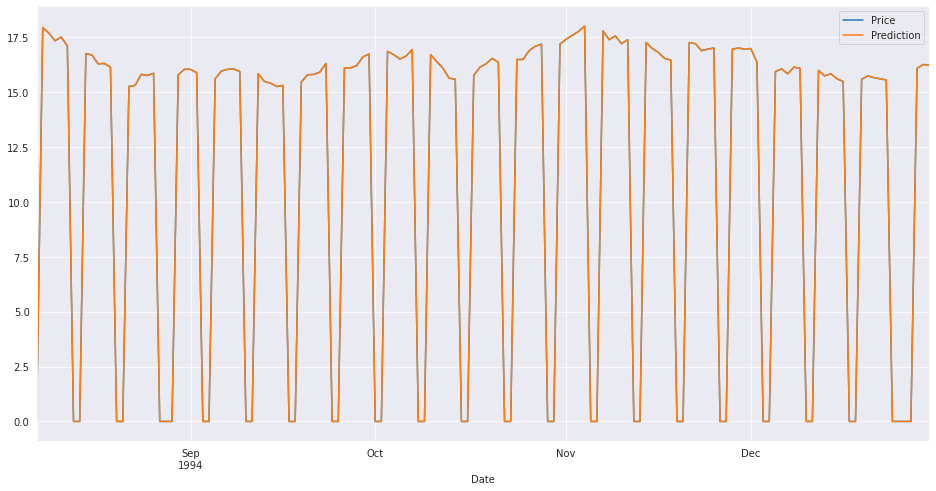

In [81]:
# We can tell it to train and to distort the prediction using holiday data
mod = SARIMAX(train_df['Price'], exog=train_df[['Price']],
             order=(1,1,1), seasonal_order=(2,0,0,7))
res = mod.fit()
start = len(train_df)
end = len(train_df) + len(test_df) - 1
prediction = res.predict(start, end, exog=test_df[['Price']]).rename('Prediction')

# As you can see from the plot that holiday has nothing to do with the price of oil
ax = test_df['Price'].plot(legend=True, figsize=(16,8))
prediction.plot(legend=True)